# Deep Learning Project

## Final report

## Study of the impact on the ratio of unlabeled to labeled data on top-1 accuracy on the CIFAR-10 dataset and House Numbers dataset

Pierre Andurand (pa2570)
Tzu Yi Chuang (tc3075)
Kuan Yu Ko (kk3376)

We hereby investigate the role of the unlabeled to labeled data ratio on the accuracy of the Self Training Noised Student Model (STNS). This is the latest state-of-the-art semi supervised computer vision algorithm which is claimed to improve ImageNet classification. 
We test STNS on 2 separate algorithms: a relatively simple convolutional neural network (Simple Model), and a more complex one: Resnet20. 2 datasets are tried out: House Numbers, and CIFAR10.
For the Student Model, we add a Dropout(0.5) layer as the penultimate layer. We also investigate the effect of adding extra noise to the Student Model by running data augmentation on the images. So we will do tests with data augmentation (DA), and without data augmentation (NDA).
We assess different types of tests. With Test1, we investigate if we could increase the accuracy of the fully supervised algorithm on the full dataset with the help of STNS. We first run the fully supervised algorithm on the labeled dataset. We then run STNS with different ratios and investigate its impact on accuracy on test data.
For Test2, we take a balanced sample of 5000 images which becomes our labeled dataset. We run the fully supervised algorithm on it. We then run STNS using a part of the remaining dataset which we use as unlabeled. The size of the unlabeled dataset used is controlled by the chosen ratio of unlabeled/labeled data. We investigate is there is an optimal ratio to use for semi supervised learning, or if it is too dependent of the underlying algorithm used and the datasets and other hyparameters.
The fully supervised algorithm is trained for 100 epochs, a level of epochs above which there is very little improvement.
The learning rate used for the teacher model is 0.001 for the first 80 epochs, and then 0.0001 for the following 20 epochs. We use a mini batch of 32 for the teacher.
We then do 2 loops of Student-Teacher in STNS, which each loop having 10 epochs. We use the Adam optimizer, and a learning rate of lr=0.0001 for the Student, and a mini batch of 136 for the student. 
For Test 1 we used the same parameters as above. 
We try soft labels, hard labels, and hard labels with a probability threshold of 0.85 (only keeping the unlabeled images that are predicted with a probability higher than 0.85)

In [7]:
# Resnet for CIFAR10 taken from Keras https://keras.io/examples/cifar10_resnet/



import matplotlib.pyplot as plt
import tensorflow as tf
# limit GPU memory to stop kernel crash
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # select GPU
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
layers = tf.keras.layers
import numpy as np
print(tf.__version__)
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import os


def prepare_cifar10_data(subtract_pixel_mean = True):
    
    # The data, split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    num_classes=10
    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train),(x_test,y_test) 
    

    
def prepare_house_numbers_data(subtract_pixel_mean = True):
    ## We import housenumber dataset from http://ufldl.stanford.edu/housenumbers/

    #Loading dataset
    num_classes=10
    from scipy.io import loadmat

    train = loadmat('train_32x32.mat')
    test = loadmat('test_32x32.mat')

    # train and test are python dictionaries
    # keys are ['__header__', '__version__', '__globals__', 'X', 'y']

    x_train = train['X']
    y_train = train['y']
    x_test = test['X']
    y_test = test['y']

    # x and y are numpy ndarrays

    print("Shape of x_train is:", x_train.shape)
    print("Shape of y_train is:", y_train.shape)
    print("Shape of x_test is:", x_test.shape)
    print("Shape of y_test is:", y_test.shape)

    x_train = x_train[:,:,:,:]
    x_test = x_test[:,:,:,:]

    x_train = np.rollaxis(x_train, 3)
    x_test = np.rollaxis(x_test, 3)

    print("Shape of x_train is now:", x_train.shape)
    print("Shape of x_test is now:", x_test.shape)

    y_train = y_train[:,0]
    y_test = y_test[:,0]

    print("Shape of y_train is now:", y_train.shape)
    print("Shape of y_test is now:", y_test.shape)

    y_train[y_train==10] = 0
    y_test[y_test==10] = 0

    print("labels of y_train are", np.unique(y_train[:]))
    print("labels of y_test are", np.unique(y_test[:]))
    
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train),(x_test,y_test) 
    

#Defining Resnet20 model




# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------






def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




def choose_resnet_model(input_shape, n=3, version=1):
    
    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)


    # Input image dimensions.
    #input_shape = x_train.shape[1:]

    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])

    init = model.get_weights()

    return model, init, model_type



def choose_simple_teacher_model(input_shape, num_classes=10):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])

    init = model.get_weights()

    return model, init


    

def train_model(init, model, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, 
                model_name= 'keras_cifar10_trained_teacher.h5'):
    
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    
    model.set_weights(init)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
    
    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
    callbacks = [checkpoint, lr_reducer, lr_scheduler]
    
    # This will do preprocessing and realtime data augmentation:
    print("Using real-time data augmentation.")
    datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

    datagen.fit(x_train)

    # Fit the noised student model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs, verbose=1, workers=4,validation_data=(x_test,y_test), callbacks=callbacks)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Supervised learning model with '+str(epochs)+'epochs \n')
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

    
    # Save model and weights
    model.save(filepath)
    print('Saved trained model at %s ' % filepath)

    return scores[1], filepath






8 Physical GPUs, 1 Logical GPUs
2.1.0


 
# Test 1
Below we would like to check if starting from the weights of the fully supervised model trained above, we would get an increase in accuracy if we run STNS on the full dataset with different ratios of unlabeled to labeled data. And if the accuracy goes up, we would like to see what is the optimal ratio. 
The STNS algorithm used is as follows:
We do a loop over different ratios of label to unlabelled data (rate). And each loop does the following:
1) take the weights from the fully supervised teacher model trained in box above 
2) X cycles of: un-noised model (teacher)->predict hard pseudolabel->training 10 epochs for noised model (student=teacher+dropout noise) on labeled+pseudo labeled->new weights. 
X is what is called loop in the code.
The student model will be the teacher model noised by a Dropout(0.5) before the last layer. And we can also use data augmentation to add to the noise for the student model.
We train the teacher on the full labeled dataset with 100 epochs. We use the Adam optimizer with the first 80 epochs using a learning rate of 0.0001, and the following 20 using 0.0001. The mini batch used is 32. Then we do 2 loops of STNS for each ratio, with a learning rate of 0.0001 and a mini batch of 136. 

In [8]:
#Defining noised Student with a Dropout(0.5) just before the output layer


def noised_resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dropout(0.5)(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def noised_resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dropout(0.5)(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def choose_noised_resnet_model(input_shape, n=3, version=1):

    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)
    if version == 2:
        model = noised_resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = noised_resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
    
    print(model_type)
    
    return model 




def choose_simple_student_model(input_shape, num_classes=10, lr=0.0001):
    #Model we used in the Milestone. Much quicker to run than Resnet. To be used to do quick tests.
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])


    return model










In [19]:
def stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, data_augmentation, 
                      loops=2, lr=0.0001, hard_labels=False, proba=0.5):
    
    # lr is the learning rate for the student only
    
    num_classes=10

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
                # set input mean to 0 over the dataset
                featurewise_center=False,
                # set each sample mean to 0
                samplewise_center=False,
                # divide inputs by std of dataset
                featurewise_std_normalization=False,
                # divide each input by its std
                samplewise_std_normalization=False,
                # apply ZCA whitening
                zca_whitening=False,
                # epsilon for ZCA whitening
                zca_epsilon=1e-06,
                # randomly rotate images in the range (deg 0 to 180)
                rotation_range=0,
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # set range for random shear
                shear_range=0.,
                # set range for random zoom
                zoom_range=0.,
                # set range for random channel shifts
                channel_shift_range=0.,
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                # value used for fill_mode = "constant"
                cval=0.,
                # randomly flip images
                horizontal_flip=True,
                # randomly flip images
                vertical_flip=False,
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0.0)
    
    
    # rate= n_pseudo/n_true, unlabeled to labeled ratio
    
    n_total=x_train.shape[0]

    # total number of train images (n_total) = number of true label images (n_true) + number of pseudo label images (n_pseudo)
    #                                        = n_pseudo(1/rate+1)
    # n_pseudo = n_total/(1/rate+1); n_true=n_total-n_pseudo

    #loop over rate values in order to find the optimal rate value for the self-learning semi supervised learning, 
    #ie one that will maximize accuracy
    j=0
    accuracy=np.zeros(rate.shape[0])
    for r in rate:
    
        print("rate="+str(r)+":\n")
        n_pseudo=n_total/(1+(1/r))
        n_true=n_total-n_pseudo
        mask_true=np.random.choice(int(n_total),int(n_true),replace=False) #generating n_true integers between 0 and n_total-1
        mask_pseudo=[item for item in range(n_total) if item not in mask_true] #all the other numbers between 0 and n_total-1 which are not in mask_true
        mask_pseudo=np.array(mask_pseudo)
        x_true=x_train[mask_true[:]] #x for the labeled data
        y_true=y_train[mask_true[:]] #y for the labeled data
        x_pseudo=x_train[mask_pseudo[:]] #x for the unlabeled data (pseudo)
        #Taking weights from supervised model on full data (box above) 
        teacher.load_weights(teacher_path)
        teacher.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
        #evaluating teacher model on test data    
        scores=teacher.evaluate(x_test,y_test,verbose=0)
        print("Original model with labelled data only predicting on test data: ",scores[1])

        x_true_pseudo=np.concatenate([x_true,x_pseudo]) #concatenating x for labeled and unlabeled data
        print('x_true_pseudo.shape: ',x_true_pseudo.shape)
        
        
        y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
        
        if hard_labels==True:
            #now we only take the high proba (>proba) unlabeled images
            mask_high=np.max(y_pseudo,axis=-1)>proba
            y_pseudo = y_pseudo.argmax(axis=-1) 
            y_pseudo_high=y_pseudo[mask_high]
            y_pseudo_high=keras.utils.to_categorical(y_pseudo_high, num_classes) 
            x_pseudo_high=x_pseudo[mask_high,:]
            x_pseudo=x_pseudo_high
            y_pseudo=y_pseudo_high
        
        
        y_true_pseudo=np.concatenate([y_true,y_pseudo]) #concatenating y for labeled and pseudo labeled
        print('y_true_pseudo.shape: ', y_true_pseudo.shape)
        student.load_weights(teacher_path)
        for i in range(loops): 
            # loops of 10 epochs of noised student training for labeled and pseudo labeled data (step 3 in article)
            # followed by generating predictions on unlabeled data with the teacher model (=un-noised student)
            # which uses the weights of the trained noised student (noise does not change the weights structure of models) (step 2 in article)

            student.compile(loss='categorical_crossentropy',
                              optimizer=Adam(learning_rate=lr),
                              metrics=['accuracy'])
          

            # Fit the noised student model 
            if data_augmentation==False:
                training=student.fit(x_true_pseudo, y_true_pseudo, batch_size=136,
                                epochs=10, verbose=1, workers=4)
            else:
                datagen.fit(x_true_pseudo)
                training=student.fit_generator(datagen.flow(x_true_pseudo, y_true_pseudo, batch_size=136),
                                epochs=10, verbose=1, workers=4)

            # Save weights
            weights=student.get_weights()
            # Load weights for teacher model (un-noised)
            teacher.set_weights(weights)
            
            y_pseudo=teacher.predict(x_pseudo)
            
            if hard_labels==True:
                y_pseudo = y_pseudo.argmax(axis=-1) 
                y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes) 
            
            scores=teacher.evaluate(x_test,y_test,verbose=0) #evaluating model on test data
            print('iteration: ',i)
            print('Test loss:', scores[0])
            print('Test accuracy:', scores[1])

            y_true_pseudo=np.concatenate([y_true,y_pseudo]) #new y_true_pseudo to be used in next loop
            
        accuracy[j]=scores[1]
        j+=1

    supervised=[accuracy_supervised for i in range(len(rate))]
    plt.plot(rate,accuracy)
    plt.plot(rate,supervised,'r')
    plt.xlabel('Rate')
    plt.ylabel('Accuracy top 1')
    if data_augmentation==False:
        plt.title('Test1 - Accuracy as a function of rate - No data augmentation')
    else:
        plt.title('Test1 - Accuracy as a function of rate - with data augmentation')
    plt.show()
    
    return accuracy

# Test 2
Now, we take a subset of 5,000 pictures that we use as labeled, and use part of the rest of the dataset as unlabeled. We run the teacher model on that labeled dataset. And then run STNS. We do that for different rate levels, and compare accuracies.
We investigate different number of Student loops (variable: loops), different learning rates for the Student model (lr=0.0001 and 0.001), and if we add data augmentation to the student or not (DA vs NDA). We investigate different types of labels (soft, hard, hard with proba threshold). And also the ratio of minibatch between the student training and teacher training (4x)


In [10]:
# Varying the ratio for 5000 labeled images. Rest of training dataset unlabeled with ratio determining size of total dataset.
# Testing on full test dataset



def prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=10):
    #Creating a balanced dataset of 5000 images (500 per class)
    total_size=x_train.shape[0]   
    print(total_size)
    print(y_train.shape)
    y_train=y_train.argmax(axis=-1)
    print(y_train.shape)
    #checking that classes are balanced
    for i in range(num_classes):
        print(str(i)+":",sum(y_train==i))

    #Selecting 500 images of each class
    k=0
    x_true=np.zeros((sample_size,32,32,3))
    y_true=np.full((sample_size,),-1)
    mask2=[]
    for i in range(total_size):
        #print(i)
        for j in range(num_classes):
            if sum(y_true==j)<sample_size/num_classes:
                if y_train[i]==j:
                    x_true[k,:]=x_train[i,:]
                    y_true[k]=y_train[i]
                    k+=1
                    mask2.append(i)
                    break
        #print('k=',k)
        if k==sample_size:
            break
        
    #print(y_small_train[0:40])
    print(x_true.shape)
    print(y_true.shape)


    #verifying that there are 500 images in each class
    for i in range(num_classes):
        print(str(i)+":",sum(y_true==i))
    
    y_true=keras.utils.to_categorical(y_true, 10)
    
    return x_true, y_true, mask2
 
#x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size, num_classes=num_classes)
    
#accuracy2_supervised, teacher2_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
#                                                      num_classes=num_classes, epochs=epochs, 
#                                                       model_name= model_name)    
    
    
# print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
# print('Test accuracy:', accuracy2_supervised)    
    
    
def stns_5000(accuracy2_supervised, mask2, teacher2_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=False,proba=0.5):
    
    
    #data_augmentation is if we add noise to the data entered to the student
    # lr is the learning rate for the student only
    
    total_size=x_train.shape[0]
    num_classes=10

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)
    
    
    
    
    
    mask3=[i for i in range(total_size) if i not in mask2]
    x_total_unlabeled=x_train[mask3,:]
    print("size x_total_unlabeled: ", x_total_unlabeled.shape[0])
    
    # rate= n_pseudo/n_true, n_true=sample_size

    number_rate=len(rate)
    
    #n_total=sample_size*(1+rate)

    # total number of train images (n_total) = number of true label images (sample_size) + number of pseudo label images (n_pseudo)
    #                                        = sample_size(rate+1)
    # n_pseudo = sample_size*rate

    #loop over rate values in order to find the optimal rate value for the self-learning semi supervised learning, 
    #ie one that will maximize accuracy
    
    accuracy2=np.zeros(number_rate)
    j=0
    for r in rate:
    
        teacher.load_weights(teacher2_path)
        student.load_weights(teacher2_path)
    
        print("rate="+str(r)+":\n")
        n_pseudo=int(sample_size*r)
        n_true=sample_size
        n_total=n_true+n_pseudo
        print("n_total, n_true, n_pseudo: ", n_total, n_true, n_pseudo)
        x_pseudo=x_total_unlabeled[0:n_pseudo,:] #x for the unlabeled data (pseudo)
        
        y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
        
        if hard_labels==True:
            #now we only take the high proba (>proba) unlabeled images
            mask_high=np.max(y_pseudo,axis=-1)>proba
            y_pseudo = y_pseudo.argmax(axis=-1) 
            y_pseudo_high=y_pseudo[mask_high]
            y_pseudo_high=keras.utils.to_categorical(y_pseudo_high, num_classes) 
            x_pseudo_high=x_pseudo[mask_high,:]
            x_pseudo=x_pseudo_high
            y_pseudo=y_pseudo_high
        
        x_true_pseudo=np.concatenate([x_true,x_pseudo]) #concatenating x for labeled and unlabeled data
        print('x_true_pseudo.shape: ',x_true_pseudo.shape)
        y_true_pseudo=np.concatenate([y_true,y_pseudo]) #concatenating y for labeled and pseudo labeled
        print('y_true_pseudo.shape: ',y_true_pseudo.shape)
        #print('y_true_pseudo.shape: ', y_true_pseudo.shape)
        
        for i in range(loops): 
            # Loops of 10 epochs of noised student training for labeled and pseudo labeled data (step 3 in article)
            # followed by generating predictions on unlabeled data with the teacher model (=un-noised student)
            # which uses the weights of the trained noised student (noise does not change the weights structure of models) (step 2 in article)
            print(i)
            student.compile(loss='categorical_crossentropy',
                              optimizer=Adam(learning_rate=0.0001),
                              metrics=['accuracy'])
            
            # Fit the noised student model 
            if data_augmentation==False:
                training=student.fit(x_true_pseudo, y_true_pseudo, batch_size=136,
                                epochs=10, verbose=1, workers=4)
            else:
                datagen.fit(x_true_pseudo)
                training=student.fit_generator(datagen.flow(x_true_pseudo, y_true_pseudo, batch_size=136),
                                epochs=10, verbose=1, workers=4)
            
            # Save weights
            weights=student.get_weights()
            # Load weights for teacher model (un-noised)
            teacher.set_weights(weights)
            y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
            
            if hard_labels==True:
                y_pseudo = y_pseudo.argmax(axis=-1) 
                y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes)
            
            scores3=teacher.evaluate(x_test,y_test,verbose=0) #evaluating model on test data
            print('iteration: ',i)
            print('Test loss:', scores3[0])
            print('Test accuracy:', scores3[1])
            y_true_pseudo=np.concatenate([y_true,y_pseudo]) #new y_true_pseudo to be used in next loop
    
        accuracy2[j]=scores3[1]
        j+=1

    supervised2=[accuracy2_supervised for i in range(number_rate)]
    plt.plot(rate, accuracy2)
    plt.plot(rate, supervised2,'r')
    plt.xlabel('Rate')
    plt.ylabel('Accuracy top 1')
    if data_augmentation==False:
        plt.title('Test2 - Accuracy as a function of rate - No data augmentation')
    else:
        plt.title('Test2 - Accuracy as a function of rate - with data augmentation')
    plt.show()
    
    return accuracy2
    
    


# Running tests below
As we ran different notebooks on different GPUs, here we run very light versions (low loops, and low epochs) to show that the code works. The results are in a separate file and were hardcoded, copying the results of each GPU

Learning rate:  0.001
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
157/157 [==============================] - 7s 42ms/step - loss: 2.0197 - accuracy: 0.2500 - val_loss: 1.7312 - val_accuracy: 0.3442
Epoch 2/100
Learning rate:  0.001
 22/157 [===>..........................] - ETA: 1s - loss: 1.7296 - accuracy: 0.3494

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


157/157 [==============================] - 3s 20ms/step - loss: 1.6796 - accuracy: 0.3820 - val_loss: 1.5529 - val_accuracy: 0.4299
Epoch 3/100
Learning rate:  0.001
157/157 [==============================] - 3s 18ms/step - loss: 1.5381 - accuracy: 0.4310 - val_loss: 1.4204 - val_accuracy: 0.4811
Epoch 4/100
Learning rate:  0.001
157/157 [==============================] - 3s 18ms/step - loss: 1.4564 - accuracy: 0.4654 - val_loss: 1.3709 - val_accuracy: 0.5005
Epoch 5/100
Learning rate:  0.001
157/157 [==============================] - 3s 19ms/step - loss: 1.3658 - accuracy: 0.4930 - val_loss: 1.2669 - val_accuracy: 0.5495
Epoch 6/100
Learning rate:  0.001
157/157 [==============================] - 3s 21ms/step - loss: 1.3238 - accuracy: 0.5080 - val_loss: 1.2748 - val_accuracy: 0.5425
Epoch 7/100
Learning rate:  0.001
157/157 [==============================] - 3s 19ms/step - loss: 1.2676 - accuracy: 0.5456 - val_loss: 1.2605 - val_accuracy: 0.5511
Epoch 8/100
Learning rate:  0.001
157/

157/157 [==============================] - 4s 23ms/step - loss: 0.3604 - accuracy: 0.8760 - val_loss: 1.3671 - val_accuracy: 0.6500
Epoch 52/100
Learning rate:  0.001
157/157 [==============================] - 3s 20ms/step - loss: 0.3439 - accuracy: 0.8750 - val_loss: 1.3566 - val_accuracy: 0.6664
Epoch 53/100
Learning rate:  0.001
157/157 [==============================] - 3s 19ms/step - loss: 0.3512 - accuracy: 0.8758 - val_loss: 1.3438 - val_accuracy: 0.6539
Epoch 54/100
Learning rate:  0.001
157/157 [==============================] - 3s 19ms/step - loss: 0.3523 - accuracy: 0.8782 - val_loss: 1.3649 - val_accuracy: 0.6624
Epoch 55/100
Learning rate:  0.001
157/157 [==============================] - 3s 21ms/step - loss: 0.3430 - accuracy: 0.8822 - val_loss: 1.3400 - val_accuracy: 0.6608
Epoch 56/100
Learning rate:  0.001
157/157 [==============================] - 3s 19ms/step - loss: 0.3307 - accuracy: 0.8828 - val_loss: 1.3286 - val_accuracy: 0.6647
Epoch 57/100
Learning rate:  0.00

10000/10000 [==============================] - 1s 86us/step
Supervised learning model with 100epochs 

Test loss: 1.6886836550474167
Test accuracy: 0.6804999709129333
Saved trained model at /home/ubuntu/saved_models/SM_CIFAR_trained_teacher_5000.h5 
Small sample of 5000 training images, Supervised learning model with 100epochs 

Test accuracy: 0.6804999709129333
size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 1s 223us/step - loss: 0.5064 - accuracy: 0.8656
Epoch 2/10
5500/5500 [==============================] - 0s 48us/step - loss: 0.4852 - accuracy: 0.8669
Epoch 3/10
5500/5500 [==============================] - 0s 49us/step - loss: 0.4613 - accuracy: 0.8791
Epoch 4/10
5500/5500 [==============================] - 1s 91us/step - loss: 0.4609 - accuracy: 0.8684
Epoch 5/10
5500/5500 [==============================] - 0s 86us

8750/8750 [==============================] - 0s 48us/step - loss: 0.6474 - accuracy: 0.8125
Epoch 6/10
8750/8750 [==============================] - 1s 102us/step - loss: 0.6339 - accuracy: 0.8152
Epoch 7/10
8750/8750 [==============================] - 0s 54us/step - loss: 0.6218 - accuracy: 0.8150
Epoch 8/10
8750/8750 [==============================] - 1s 75us/step - loss: 0.6107 - accuracy: 0.8137
Epoch 9/10
8750/8750 [==============================] - 1s 77us/step - loss: 0.5835 - accuracy: 0.8213
Epoch 10/10
8750/8750 [==============================] - 0s 48us/step - loss: 0.5829 - accuracy: 0.8185
iteration:  0
Test loss: 1.11514135761261
Test accuracy: 0.6869999766349792
1
Epoch 1/10
8750/8750 [==============================] - 1s 90us/step - loss: 0.6111 - accuracy: 0.8242
Epoch 2/10
8750/8750 [==============================] - 1s 71us/step - loss: 0.5881 - accuracy: 0.8269
Epoch 3/10
8750/8750 [==============================] - 1s 79us/step - loss: 0.5695 - accuracy: 0.8376
Epoc

30000/30000 [==============================] - 2s 80us/step - loss: 0.7859 - accuracy: 0.8011
Epoch 5/10
30000/30000 [==============================] - 2s 66us/step - loss: 0.7809 - accuracy: 0.8073
Epoch 6/10
30000/30000 [==============================] - 2s 81us/step - loss: 0.7760 - accuracy: 0.8078
Epoch 7/10
30000/30000 [==============================] - 2s 64us/step - loss: 0.7708 - accuracy: 0.8078
Epoch 8/10
30000/30000 [==============================] - 2s 73us/step - loss: 0.7701 - accuracy: 0.8120
Epoch 9/10
30000/30000 [==============================] - 2s 69us/step - loss: 0.7643 - accuracy: 0.8133
Epoch 10/10
30000/30000 [==============================] - 2s 72us/step - loss: 0.7609 - accuracy: 0.8185
iteration:  1
Test loss: 0.9181212965965271
Test accuracy: 0.6877999901771545
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (42500, 32, 32, 3)
y_true_pseudo.shape:  (42500, 10)
0
Epoch 1/10
42500/42500 [==============================] - 4s 87u

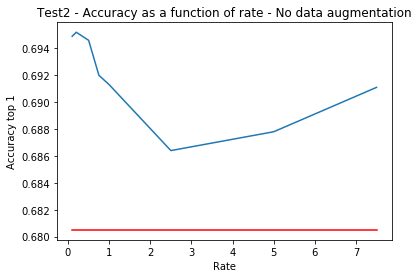

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 1s 128us/step - loss: 0.5022 - accuracy: 0.8622
Epoch 2/10
5500/5500 [==============================] - 0s 48us/step - loss: 0.4700 - accuracy: 0.8673
Epoch 3/10
5500/5500 [==============================] - 1s 93us/step - loss: 0.4659 - accuracy: 0.8709
Epoch 4/10
5500/5500 [==============================] - 1s 94us/step - loss: 0.4461 - accuracy: 0.8749
Epoch 5/10
5500/5500 [==============================] - 0s 47us/step - loss: 0.4068 - accuracy: 0.8713
Epoch 6/10
5500/5500 [==============================] - 0s 47us/step - loss: 0.4319 - accuracy: 0.8713
Epoch 7/10
5500/5500 [==============================] - 1s 94us/step - loss: 0.4103 - accuracy: 0.8813
Epoch 8/10
5500/5500 [==============================] - 1s 94us/step - loss: 0.3863 - accuracy: 0.8802
Epoch 9/10
5500/

8750/8750 [==============================] - 0s 47us/step - loss: 0.5314 - accuracy: 0.8257
iteration:  0
Test loss: 1.1800260996818543
Test accuracy: 0.6899999976158142
1
Epoch 1/10
8750/8750 [==============================] - 1s 144us/step - loss: 0.5123 - accuracy: 0.8259
Epoch 2/10
8750/8750 [==============================] - 1s 74us/step - loss: 0.4949 - accuracy: 0.8368
Epoch 3/10
8750/8750 [==============================] - 0s 46us/step - loss: 0.4766 - accuracy: 0.8385
Epoch 4/10
8750/8750 [==============================] - 1s 81us/step - loss: 0.4761 - accuracy: 0.8371
Epoch 5/10
8750/8750 [==============================] - 1s 67us/step - loss: 0.4537 - accuracy: 0.8462
Epoch 6/10
8750/8750 [==============================] - 1s 68us/step - loss: 0.4353 - accuracy: 0.8502
Epoch 7/10
8750/8750 [==============================] - 1s 78us/step - loss: 0.4441 - accuracy: 0.8447
Epoch 8/10
8750/8750 [==============================] - 0s 48us/step - loss: 0.4484 - accuracy: 0.8417
Epo

30000/30000 [==============================] - 2s 76us/step - loss: 0.4807 - accuracy: 0.8194
Epoch 10/10
30000/30000 [==============================] - 2s 71us/step - loss: 0.4622 - accuracy: 0.8277
iteration:  1
Test loss: 1.101010643863678
Test accuracy: 0.6917999982833862
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (42500, 32, 32, 3)
y_true_pseudo.shape:  (42500, 10)
0
Epoch 1/10
42500/42500 [==============================] - 4s 84us/step - loss: 1.0767 - accuracy: 0.7173
Epoch 2/10
42500/42500 [==============================] - 3s 71us/step - loss: 0.8413 - accuracy: 0.7293
Epoch 3/10
42500/42500 [==============================] - 3s 77us/step - loss: 0.7524 - accuracy: 0.7440
Epoch 4/10
42500/42500 [==============================] - 3s 71us/step - loss: 0.7269 - accuracy: 0.7475
Epoch 5/10
42500/42500 [==============================] - 3s 69us/step - loss: 0.6929 - accuracy: 0.7536
Epoch 6/10
42500/42500 [==============================] - 3s 70us

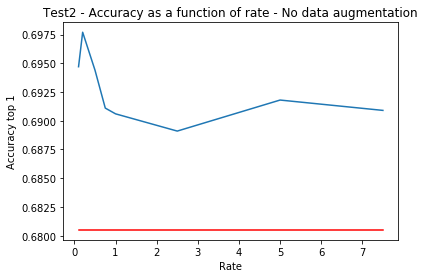

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5355, 32, 32, 3)
y_true_pseudo.shape:  (5355, 10)
0
Epoch 1/10
5355/5355 [==============================] - 1s 123us/step - loss: 0.4346 - accuracy: 0.8799
Epoch 2/10
5355/5355 [==============================] - 0s 79us/step - loss: 0.4224 - accuracy: 0.8820
Epoch 3/10
5355/5355 [==============================] - 1s 95us/step - loss: 0.4087 - accuracy: 0.8848
Epoch 4/10
5355/5355 [==============================] - 0s 46us/step - loss: 0.3747 - accuracy: 0.8898
Epoch 5/10
5355/5355 [==============================] - 1s 98us/step - loss: 0.3639 - accuracy: 0.8913
Epoch 6/10
5355/5355 [==============================] - 0s 47us/step - loss: 0.3319 - accuracy: 0.8971
Epoch 7/10
5355/5355 [==============================] - 1s 96us/step - loss: 0.3472 - accuracy: 0.8930
Epoch 8/10
5355/5355 [==============================] - 0s 46us/step - loss: 0.3349 - accuracy: 0.8887
Epoch 9/10
5355/

7743/7743 [==============================] - 1s 78us/step - loss: 0.3849 - accuracy: 0.8763
iteration:  0
Test loss: 1.2878069398880005
Test accuracy: 0.6933000087738037
1
Epoch 1/10
7743/7743 [==============================] - 1s 138us/step - loss: 0.3724 - accuracy: 0.8749
Epoch 2/10
7743/7743 [==============================] - 1s 80us/step - loss: 0.3607 - accuracy: 0.8870
Epoch 3/10
7743/7743 [==============================] - 1s 78us/step - loss: 0.3597 - accuracy: 0.8774
Epoch 4/10
7743/7743 [==============================] - 0s 47us/step - loss: 0.3625 - accuracy: 0.8795
Epoch 5/10
7743/7743 [==============================] - 1s 78us/step - loss: 0.3371 - accuracy: 0.8869
Epoch 6/10
7743/7743 [==============================] - 1s 70us/step - loss: 0.3327 - accuracy: 0.8880
Epoch 7/10
7743/7743 [==============================] - 0s 47us/step - loss: 0.3197 - accuracy: 0.8863
Epoch 8/10
7743/7743 [==============================] - 1s 82us/step - loss: 0.3002 - accuracy: 0.8947
Epo

23360/23360 [==============================] - 2s 74us/step - loss: 0.3180 - accuracy: 0.8867
Epoch 10/10
23360/23360 [==============================] - 2s 74us/step - loss: 0.3169 - accuracy: 0.8879
iteration:  1
Test loss: 1.146810748577118
Test accuracy: 0.6978999972343445
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (32558, 32, 32, 3)
y_true_pseudo.shape:  (32558, 10)
0
Epoch 1/10
32558/32558 [==============================] - 3s 92us/step - loss: 0.7612 - accuracy: 0.8022
Epoch 2/10
32558/32558 [==============================] - 2s 70us/step - loss: 0.6065 - accuracy: 0.8192
Epoch 3/10
32558/32558 [==============================] - 2s 72us/step - loss: 0.5305 - accuracy: 0.8309
Epoch 4/10
32558/32558 [==============================] - 3s 79us/step - loss: 0.4948 - accuracy: 0.8372
Epoch 5/10
32558/32558 [==============================] - 2s 59us/step - loss: 0.4639 - accuracy: 0.8440
Epoch 6/10
32558/32558 [==============================] - 3s 77us

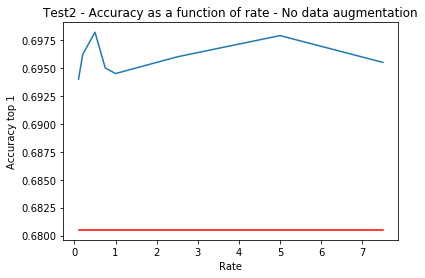

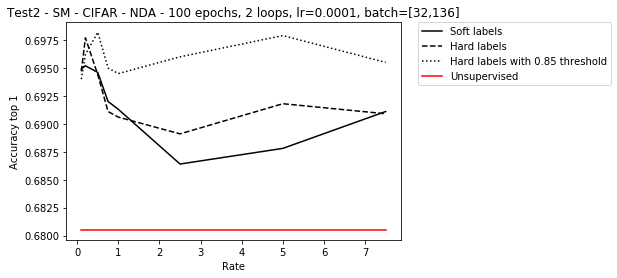

In [5]:
#Running Test2 for CIFAR10 NDA with Simple model

epochs=100
loops=2

num_classes=10
(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init = choose_simple_teacher_model(input_shape=x_train.shape[1:])
student = choose_simple_student_model(input_shape=x_train.shape[1:])
rate=np.array([0.1,0.2,0.5,0.75,1,2.5,5, 7.5])
model_name= 'SM_CIFAR_trained_teacher_5000.h5'

x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=num_classes)
    
accuracy_supervised, teacher_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
                                                      num_classes=num_classes, epochs=epochs, 
                                                       model_name= model_name)    
    
    
print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
print('Test accuracy:', accuracy_supervised)    

accuracy1 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=False)

accuracy2 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy3 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


supervised=[accuracy_supervised for i in range(len(rate))]

plt.plot(rate, accuracy1, 'k', label='Soft labels')
plt.plot(rate, accuracy2, 'k--', label='Hard labels')
plt.plot(rate, accuracy3, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - SM - CIFAR - NDA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 2s 50ms/step - loss: 0.7865 - accuracy: 0.8024
Epoch 2/10
41/41 [==============================] - 2s 50ms/step - loss: 0.6895 - accuracy: 0.8080
Epoch 3/10
41/41 [==============================] - 2s 44ms/step - loss: 0.7594 - accuracy: 0.8035
Epoch 4/10
41/41 [==============================] - 2s 49ms/step - loss: 0.7002 - accuracy: 0.8051
Epoch 5/10
41/41 [==============================] - 2s 51ms/step - loss: 0.7167 - accuracy: 0.8047
Epoch 6/10
41/41 [==============================] - 2s 47ms/step - loss: 0.6393 - accuracy: 0.8149
Epoch 7/10
41/41 [==============================] - 2s 51ms/step - loss: 0.6296 - accuracy: 0.8125
Epoch 8/10
41/41 [==============================] - 2s 52ms/step - loss: 0.6291 - accuracy: 0.8104
Epoch 9/10
41/41 [==============================]

65/65 [==============================] - 3s 50ms/step - loss: 0.8457 - accuracy: 0.7511
Epoch 3/10
65/65 [==============================] - 3s 53ms/step - loss: 0.8428 - accuracy: 0.7485
Epoch 4/10
65/65 [==============================] - 3s 41ms/step - loss: 0.8276 - accuracy: 0.7471
Epoch 5/10
65/65 [==============================] - 3s 51ms/step - loss: 0.8195 - accuracy: 0.7552
Epoch 6/10
65/65 [==============================] - 4s 54ms/step - loss: 0.8237 - accuracy: 0.7529
Epoch 7/10
65/65 [==============================] - 3s 44ms/step - loss: 0.8031 - accuracy: 0.7581
Epoch 8/10
65/65 [==============================] - 3s 49ms/step - loss: 0.8033 - accuracy: 0.7567
Epoch 9/10
65/65 [==============================] - 3s 49ms/step - loss: 0.7958 - accuracy: 0.7634
Epoch 10/10
65/65 [==============================] - 3s 52ms/step - loss: 0.7996 - accuracy: 0.7582
iteration:  1
Test loss: 1.0441387008666991
Test accuracy: 0.6660000085830688
rate=1.0:

n_total, n_true, n_pseudo:  10

313/313 [==============================] - 14s 46ms/step - loss: 1.1283 - accuracy: 0.6420
Epoch 3/10
313/313 [==============================] - 13s 43ms/step - loss: 1.0459 - accuracy: 0.6523
Epoch 4/10
313/313 [==============================] - 13s 40ms/step - loss: 1.0030 - accuracy: 0.6638
Epoch 5/10
313/313 [==============================] - 15s 48ms/step - loss: 0.9702 - accuracy: 0.6748
Epoch 6/10
313/313 [==============================] - 15s 49ms/step - loss: 0.9448 - accuracy: 0.6832
Epoch 7/10
313/313 [==============================] - 15s 48ms/step - loss: 0.9292 - accuracy: 0.6845
Epoch 8/10
313/313 [==============================] - 13s 41ms/step - loss: 0.9128 - accuracy: 0.6894
Epoch 9/10
313/313 [==============================] - 14s 43ms/step - loss: 0.9011 - accuracy: 0.6972
Epoch 10/10
313/313 [==============================] - 16s 50ms/step - loss: 0.8990 - accuracy: 0.6954
iteration:  0
Test loss: 1.0107689960479735
Test accuracy: 0.6621000170707703
1
Epoch 1/10
3

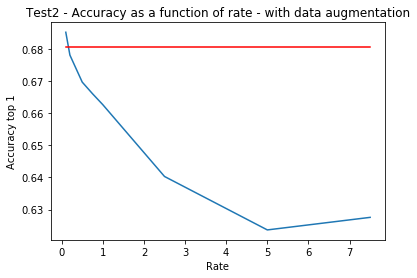

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 2s 52ms/step - loss: 0.8380 - accuracy: 0.7891
Epoch 2/10
41/41 [==============================] - 2s 49ms/step - loss: 0.7601 - accuracy: 0.8045
Epoch 3/10
41/41 [==============================] - 2s 50ms/step - loss: 0.7796 - accuracy: 0.7960
Epoch 4/10
41/41 [==============================] - 2s 46ms/step - loss: 0.7111 - accuracy: 0.8071
Epoch 5/10
41/41 [==============================] - 2s 51ms/step - loss: 0.6448 - accuracy: 0.8105
Epoch 6/10
41/41 [==============================] - 2s 49ms/step - loss: 0.6267 - accuracy: 0.8082
Epoch 7/10
41/41 [==============================] - 2s 49ms/step - loss: 0.6179 - accuracy: 0.8080
Epoch 8/10
41/41 [==============================] - 2s 46ms/step - loss: 0.6119 - accuracy: 0.8116
Epoch 9/10
41/41 [==============================]

65/65 [==============================] - 3s 52ms/step - loss: 0.7793 - accuracy: 0.7473
Epoch 3/10
65/65 [==============================] - 3s 53ms/step - loss: 0.7463 - accuracy: 0.7536
Epoch 4/10
65/65 [==============================] - 3s 47ms/step - loss: 0.7248 - accuracy: 0.7558
Epoch 5/10
65/65 [==============================] - 3s 50ms/step - loss: 0.7159 - accuracy: 0.7646
Epoch 6/10
65/65 [==============================] - 3s 51ms/step - loss: 0.7218 - accuracy: 0.7502
Epoch 7/10
65/65 [==============================] - 3s 49ms/step - loss: 0.7269 - accuracy: 0.7538
Epoch 8/10
65/65 [==============================] - 3s 47ms/step - loss: 0.7157 - accuracy: 0.7617
Epoch 9/10
65/65 [==============================] - 3s 49ms/step - loss: 0.6982 - accuracy: 0.7617
Epoch 10/10
65/65 [==============================] - 3s 53ms/step - loss: 0.6789 - accuracy: 0.7710
iteration:  1
Test loss: 1.1058929825782775
Test accuracy: 0.6626999974250793
rate=1.0:

n_total, n_true, n_pseudo:  10

313/313 [==============================] - 13s 41ms/step - loss: 1.1185 - accuracy: 0.6432
Epoch 3/10
313/313 [==============================] - 13s 41ms/step - loss: 1.0193 - accuracy: 0.6541
Epoch 4/10
313/313 [==============================] - 13s 41ms/step - loss: 0.9599 - accuracy: 0.6680
Epoch 5/10
313/313 [==============================] - 14s 43ms/step - loss: 0.9394 - accuracy: 0.6738
Epoch 6/10
313/313 [==============================] - 14s 43ms/step - loss: 0.9099 - accuracy: 0.6837
Epoch 7/10
313/313 [==============================] - 13s 41ms/step - loss: 0.8969 - accuracy: 0.6837
Epoch 8/10
313/313 [==============================] - 13s 40ms/step - loss: 0.8800 - accuracy: 0.6901
Epoch 9/10
313/313 [==============================] - 15s 48ms/step - loss: 0.8721 - accuracy: 0.6946
Epoch 10/10
313/313 [==============================] - 14s 43ms/step - loss: 0.8488 - accuracy: 0.7019
iteration:  0
Test loss: 1.037658277130127
Test accuracy: 0.6601999998092651
1
Epoch 1/10
31

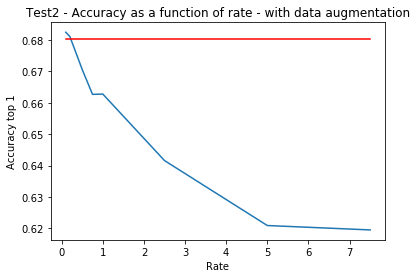

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5355, 32, 32, 3)
y_true_pseudo.shape:  (5355, 10)
0
Epoch 1/10
40/40 [==============================] - 2s 49ms/step - loss: 0.7681 - accuracy: 0.8026
Epoch 2/10
40/40 [==============================] - 2s 49ms/step - loss: 0.7069 - accuracy: 0.8140
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 0.6143 - accuracy: 0.8161
Epoch 4/10
40/40 [==============================] - 2s 46ms/step - loss: 0.6432 - accuracy: 0.8125
Epoch 5/10
40/40 [==============================] - 2s 48ms/step - loss: 0.6018 - accuracy: 0.8161
Epoch 6/10
40/40 [==============================] - 2s 52ms/step - loss: 0.5776 - accuracy: 0.8265
Epoch 7/10
40/40 [==============================] - 2s 51ms/step - loss: 0.5844 - accuracy: 0.8121
Epoch 8/10
40/40 [==============================] - 2s 55ms/step - loss: 0.5609 - accuracy: 0.8329
Epoch 9/10
40/40 [==============================]

57/57 [==============================] - 3s 44ms/step - loss: 0.6197 - accuracy: 0.7976
Epoch 3/10
57/57 [==============================] - 3s 46ms/step - loss: 0.6139 - accuracy: 0.8015
Epoch 4/10
57/57 [==============================] - 3s 48ms/step - loss: 0.5983 - accuracy: 0.8006
Epoch 5/10
57/57 [==============================] - 3s 50ms/step - loss: 0.5722 - accuracy: 0.8063
Epoch 6/10
57/57 [==============================] - 3s 51ms/step - loss: 0.5768 - accuracy: 0.7997
Epoch 7/10
57/57 [==============================] - 3s 51ms/step - loss: 0.5705 - accuracy: 0.8068
Epoch 8/10
57/57 [==============================] - 3s 50ms/step - loss: 0.5517 - accuracy: 0.8142
Epoch 9/10
57/57 [==============================] - 3s 51ms/step - loss: 0.5525 - accuracy: 0.8174
Epoch 10/10
57/57 [==============================] - 3s 49ms/step - loss: 0.5466 - accuracy: 0.8147
iteration:  1
Test loss: 1.1637106860160829
Test accuracy: 0.6743000149726868
rate=1.0:

n_total, n_true, n_pseudo:  10

240/240 [==============================] - 10s 41ms/step - loss: 0.7816 - accuracy: 0.7479
Epoch 4/10
240/240 [==============================] - 10s 41ms/step - loss: 0.7449 - accuracy: 0.7553
Epoch 5/10
240/240 [==============================] - 10s 43ms/step - loss: 0.7095 - accuracy: 0.7609
Epoch 6/10
240/240 [==============================] - 10s 43ms/step - loss: 0.6847 - accuracy: 0.7662
Epoch 7/10
240/240 [==============================] - 11s 44ms/step - loss: 0.6651 - accuracy: 0.7746
Epoch 8/10
240/240 [==============================] - 11s 44ms/step - loss: 0.6556 - accuracy: 0.7771
Epoch 9/10
240/240 [==============================] - 12s 49ms/step - loss: 0.6376 - accuracy: 0.7824
Epoch 10/10
240/240 [==============================] - 12s 50ms/step - loss: 0.6216 - accuracy: 0.7877
iteration:  0
Test loss: 1.118117537879944
Test accuracy: 0.6647999882698059
1
Epoch 1/10
240/240 [==============================] - 11s 45ms/step - loss: 0.6136 - accuracy: 0.7887
Epoch 2/10
24

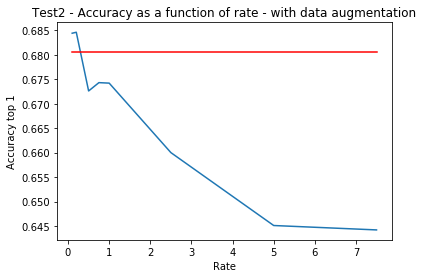

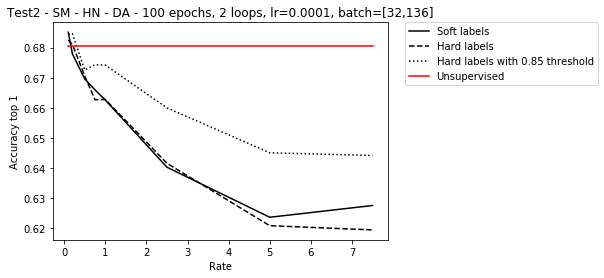

In [6]:
# Running Test2 with simple model on House Numbers with Data Augmentation

accuracy4 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=False)

accuracy5 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy6 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


plt.plot(rate, accuracy4, 'k', label='Soft labels')
plt.plot(rate, accuracy5, 'k--', label='Hard labels')
plt.plot(rate, accuracy6, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - SM - HN - DA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
157/157 [==============================] - 5s 32ms/step - loss: 2.3038 - accuracy: 0.0962 - val_loss: 2.3263 - val_accuracy: 0.1250
Epoch 2/100
Learning rate:  0.001
 10/157 [>.............................] - ETA: 2s - loss: 2.2939 - accuracy: 0.1219

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


157/157 [==============================] - 5s 35ms/step - loss: 1.9687 - accuracy: 0.2932 - val_loss: 1.6600 - val_accuracy: 0.3971
Epoch 3/100
Learning rate:  0.001
157/157 [==============================] - 5s 29ms/step - loss: 1.5867 - accuracy: 0.4448 - val_loss: 1.2802 - val_accuracy: 0.5740
Epoch 4/100
Learning rate:  0.001
157/157 [==============================] - 5s 29ms/step - loss: 1.3901 - accuracy: 0.5234 - val_loss: 1.2407 - val_accuracy: 0.5844
Epoch 5/100
Learning rate:  0.001
157/157 [==============================] - 5s 34ms/step - loss: 1.1991 - accuracy: 0.6004 - val_loss: 1.0139 - val_accuracy: 0.6771
Epoch 6/100
Learning rate:  0.001
157/157 [==============================] - 5s 31ms/step - loss: 1.0597 - accuracy: 0.6492 - val_loss: 0.8279 - val_accuracy: 0.7389
Epoch 7/100
Learning rate:  0.001
157/157 [==============================] - 4s 28ms/step - loss: 0.9217 - accuracy: 0.6972 - val_loss: 0.8185 - val_accuracy: 0.7371
Epoch 8/100
Learning rate:  0.001
157/

157/157 [==============================] - 5s 29ms/step - loss: 0.2595 - accuracy: 0.9116 - val_loss: 0.5013 - val_accuracy: 0.8675
Epoch 52/100
Learning rate:  0.001
157/157 [==============================] - 5s 32ms/step - loss: 0.2560 - accuracy: 0.9198 - val_loss: 0.5434 - val_accuracy: 0.8547
Epoch 53/100
Learning rate:  0.001
157/157 [==============================] - 5s 30ms/step - loss: 0.2744 - accuracy: 0.9130 - val_loss: 0.5152 - val_accuracy: 0.8579
Epoch 54/100
Learning rate:  0.001
157/157 [==============================] - 5s 30ms/step - loss: 0.2471 - accuracy: 0.9232 - val_loss: 0.5554 - val_accuracy: 0.8528
Epoch 55/100
Learning rate:  0.001
157/157 [==============================] - 5s 31ms/step - loss: 0.2505 - accuracy: 0.9132 - val_loss: 0.5483 - val_accuracy: 0.8632
Epoch 56/100
Learning rate:  0.001
157/157 [==============================] - 5s 31ms/step - loss: 0.2520 - accuracy: 0.9178 - val_loss: 0.5357 - val_accuracy: 0.8574
Epoch 57/100
Learning rate:  0.00

26032/26032 [==============================] - 2s 87us/step
Supervised learning model with 100epochs 

Test loss: 0.5313114515198343
Test accuracy: 0.8798786401748657
Saved trained model at /home/ubuntu/saved_models/SM_HN_trained_teacher_5000.h5 
Small sample of 5000 training images, Supervised learning model with 100epochs 

Test accuracy: 0.8798786401748657
size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 1s 130us/step - loss: 0.3634 - accuracy: 0.8964
Epoch 2/10
5500/5500 [==============================] - 0s 47us/step - loss: 0.3203 - accuracy: 0.9089
Epoch 3/10
5500/5500 [==============================] - 1s 92us/step - loss: 0.3046 - accuracy: 0.9116
Epoch 4/10
5500/5500 [==============================] - 0s 88us/step - loss: 0.2743 - accuracy: 0.9144
Epoch 5/10
5500/5500 [==============================] - 0s 46us/st

8750/8750 [==============================] - 1s 105us/step - loss: 0.3728 - accuracy: 0.8937
Epoch 6/10
8750/8750 [==============================] - 0s 46us/step - loss: 0.3756 - accuracy: 0.8889
Epoch 7/10
8750/8750 [==============================] - 1s 76us/step - loss: 0.3584 - accuracy: 0.8950
Epoch 8/10
8750/8750 [==============================] - 1s 75us/step - loss: 0.3604 - accuracy: 0.8925
Epoch 9/10
8750/8750 [==============================] - 1s 77us/step - loss: 0.3451 - accuracy: 0.9014
Epoch 10/10
8750/8750 [==============================] - 1s 77us/step - loss: 0.3401 - accuracy: 0.9007
iteration:  0
Test loss: 0.3682969586892808
Test accuracy: 0.8978564739227295
1
Epoch 1/10
8750/8750 [==============================] - 1s 110us/step - loss: 0.3368 - accuracy: 0.9082
Epoch 2/10
8750/8750 [==============================] - 1s 78us/step - loss: 0.3239 - accuracy: 0.9134
Epoch 3/10
8750/8750 [==============================] - 1s 64us/step - loss: 0.3235 - accuracy: 0.9088
E

30000/30000 [==============================] - 2s 80us/step - loss: 0.4264 - accuracy: 0.9073
Epoch 5/10
30000/30000 [==============================] - 2s 63us/step - loss: 0.4202 - accuracy: 0.9103
Epoch 6/10
30000/30000 [==============================] - 2s 81us/step - loss: 0.4215 - accuracy: 0.9099
Epoch 7/10
30000/30000 [==============================] - 2s 66us/step - loss: 0.4154 - accuracy: 0.9126
Epoch 8/10
30000/30000 [==============================] - 2s 81us/step - loss: 0.4119 - accuracy: 0.9159
Epoch 9/10
30000/30000 [==============================] - 2s 64us/step - loss: 0.4124 - accuracy: 0.9151
Epoch 10/10
30000/30000 [==============================] - 2s 80us/step - loss: 0.4081 - accuracy: 0.9148
iteration:  1
Test loss: 0.32621491893658844
Test accuracy: 0.9079978466033936
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (42500, 32, 32, 3)
y_true_pseudo.shape:  (42500, 10)
0
Epoch 1/10
42500/42500 [==============================] - 3s 80

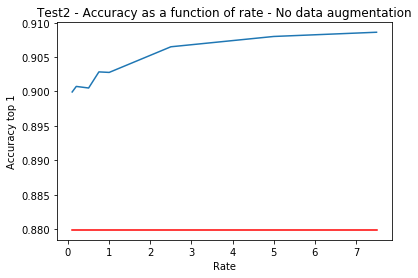

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 1s 166us/step - loss: 0.3911 - accuracy: 0.8933
Epoch 2/10
5500/5500 [==============================] - 0s 47us/step - loss: 0.3236 - accuracy: 0.9022
Epoch 3/10
5500/5500 [==============================] - 1s 96us/step - loss: 0.2925 - accuracy: 0.9156
Epoch 4/10
5500/5500 [==============================] - 1s 93us/step - loss: 0.2860 - accuracy: 0.9091
Epoch 5/10
5500/5500 [==============================] - 0s 47us/step - loss: 0.2519 - accuracy: 0.9169
Epoch 6/10
5500/5500 [==============================] - 0s 48us/step - loss: 0.2564 - accuracy: 0.9225
Epoch 7/10
5500/5500 [==============================] - 1s 95us/step - loss: 0.2370 - accuracy: 0.9244
Epoch 8/10
5500/5500 [==============================] - 0s 84us/step - loss: 0.2352 - accuracy: 0.9262
Epoch 9/10
5500/

8750/8750 [==============================] - 1s 76us/step - loss: 0.2896 - accuracy: 0.9030
iteration:  0
Test loss: 0.3828008739093402
Test accuracy: 0.8979717493057251
1
Epoch 1/10
8750/8750 [==============================] - 1s 112us/step - loss: 0.2696 - accuracy: 0.9129
Epoch 2/10
8750/8750 [==============================] - 1s 79us/step - loss: 0.2413 - accuracy: 0.9167
Epoch 3/10
8750/8750 [==============================] - 0s 48us/step - loss: 0.2536 - accuracy: 0.9194
Epoch 4/10
8750/8750 [==============================] - 1s 108us/step - loss: 0.2359 - accuracy: 0.9203
Epoch 5/10
8750/8750 [==============================] - 0s 48us/step - loss: 0.2264 - accuracy: 0.9282
Epoch 6/10
8750/8750 [==============================] - 1s 107us/step - loss: 0.2407 - accuracy: 0.9200
Epoch 7/10
8750/8750 [==============================] - 0s 48us/step - loss: 0.2264 - accuracy: 0.9229
Epoch 8/10
8750/8750 [==============================] - 1s 80us/step - loss: 0.2234 - accuracy: 0.9232
E

30000/30000 [==============================] - 2s 73us/step - loss: 0.2323 - accuracy: 0.9191
Epoch 10/10
30000/30000 [==============================] - 2s 73us/step - loss: 0.2273 - accuracy: 0.9201
iteration:  1
Test loss: 0.341955505456883
Test accuracy: 0.9078441858291626
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (42500, 32, 32, 3)
y_true_pseudo.shape:  (42500, 10)
0
Epoch 1/10
42500/42500 [==============================] - 3s 79us/step - loss: 0.5871 - accuracy: 0.8332
Epoch 2/10
42500/42500 [==============================] - 3s 79us/step - loss: 0.4675 - accuracy: 0.8494
Epoch 3/10
42500/42500 [==============================] - 3s 69us/step - loss: 0.4241 - accuracy: 0.8608
Epoch 4/10
42500/42500 [==============================] - 3s 70us/step - loss: 0.3998 - accuracy: 0.8669
Epoch 5/10
42500/42500 [==============================] - 3s 70us/step - loss: 0.3805 - accuracy: 0.8716
Epoch 6/10
42500/42500 [==============================] - 3s 69us

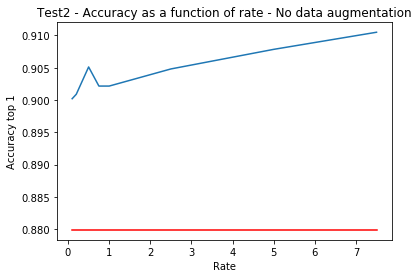

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5422, 32, 32, 3)
y_true_pseudo.shape:  (5422, 10)
0
Epoch 1/10
5422/5422 [==============================] - 1s 157us/step - loss: 0.3206 - accuracy: 0.9080
Epoch 2/10
5422/5422 [==============================] - 1s 103us/step - loss: 0.2859 - accuracy: 0.9105
Epoch 3/10
5422/5422 [==============================] - 0s 46us/step - loss: 0.2543 - accuracy: 0.9200
Epoch 4/10
5422/5422 [==============================] - 0s 47us/step - loss: 0.2695 - accuracy: 0.9181
Epoch 5/10
5422/5422 [==============================] - 1s 129us/step - loss: 0.2421 - accuracy: 0.9211
Epoch 6/10
5422/5422 [==============================] - 0s 66us/step - loss: 0.2241 - accuracy: 0.9286
Epoch 7/10
5422/5422 [==============================] - 0s 46us/step - loss: 0.2048 - accuracy: 0.9340
Epoch 8/10
5422/5422 [==============================] - 1s 97us/step - loss: 0.2167 - accuracy: 0.9305
Epoch 9/10
542

8181/8181 [==============================] - 1s 88us/step - loss: 0.1997 - accuracy: 0.9348
iteration:  0
Test loss: 0.40348898863148563
Test accuracy: 0.8992778062820435
1
Epoch 1/10
8181/8181 [==============================] - 1s 118us/step - loss: 0.1917 - accuracy: 0.9380
Epoch 2/10
8181/8181 [==============================] - 1s 79us/step - loss: 0.1697 - accuracy: 0.9413
Epoch 3/10
8181/8181 [==============================] - 1s 79us/step - loss: 0.1871 - accuracy: 0.9388
Epoch 4/10
8181/8181 [==============================] - 1s 79us/step - loss: 0.1698 - accuracy: 0.9438
Epoch 5/10
8181/8181 [==============================] - 0s 48us/step - loss: 0.1640 - accuracy: 0.9430
Epoch 6/10
8181/8181 [==============================] - 1s 112us/step - loss: 0.1767 - accuracy: 0.9418
Epoch 7/10
8181/8181 [==============================] - 0s 47us/step - loss: 0.1467 - accuracy: 0.9520
Epoch 8/10
8181/8181 [==============================] - 1s 80us/step - loss: 0.1529 - accuracy: 0.9456
E

26204/26204 [==============================] - 2s 65us/step - loss: 0.1209 - accuracy: 0.9590
Epoch 10/10
26204/26204 [==============================] - 2s 63us/step - loss: 0.1156 - accuracy: 0.9614
iteration:  1
Test loss: 0.36713528036916676
Test accuracy: 0.9074984788894653
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (36822, 32, 32, 3)
y_true_pseudo.shape:  (36822, 10)
0
Epoch 1/10
36822/36822 [==============================] - 3s 81us/step - loss: 0.3549 - accuracy: 0.8988
Epoch 2/10
36822/36822 [==============================] - 3s 73us/step - loss: 0.2641 - accuracy: 0.9158
Epoch 3/10
36822/36822 [==============================] - 3s 73us/step - loss: 0.2417 - accuracy: 0.9236
Epoch 4/10
36822/36822 [==============================] - 2s 67us/step - loss: 0.2156 - accuracy: 0.9297
Epoch 5/10
36822/36822 [==============================] - 3s 70us/step - loss: 0.1999 - accuracy: 0.9343
Epoch 6/10
36822/36822 [==============================] - 3s 72

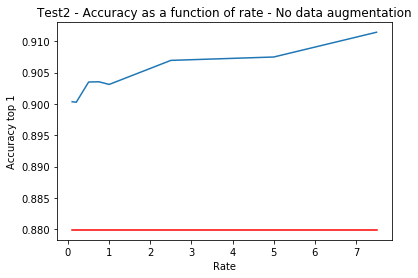

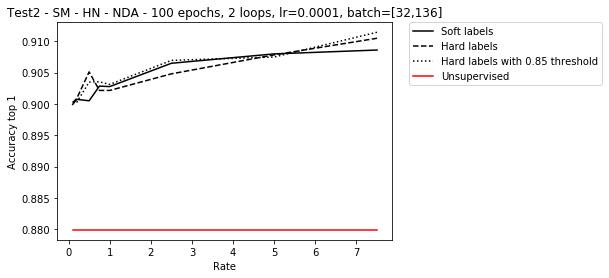

In [11]:
#Running Test2 for House Numbers NDA with Simple model

epochs=100
loops=2

num_classes=10
(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init = choose_simple_teacher_model(input_shape=x_train.shape[1:])
student = choose_simple_student_model(input_shape=x_train.shape[1:])
rate=np.array([0.1,0.2,0.5,0.75,1,2.5,5, 7.5])
model_name= 'SM_HN_trained_teacher_5000.h5'

x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=num_classes)
    
accuracy_supervised, teacher_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
                                                      num_classes=num_classes, epochs=epochs, 
                                                       model_name= model_name)    
    
    
print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
print('Test accuracy:', accuracy_supervised)    

accuracy1 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=False)

accuracy2 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy3 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


supervised=[accuracy_supervised for i in range(len(rate))]

plt.plot(rate, accuracy1, 'k', label='Soft labels')
plt.plot(rate, accuracy2, 'k--', label='Hard labels')
plt.plot(rate, accuracy3, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - SM - HN - NDA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 2s 53ms/step - loss: 0.5837 - accuracy: 0.8504
Epoch 2/10
41/41 [==============================] - 2s 48ms/step - loss: 0.5278 - accuracy: 0.8598
Epoch 3/10
41/41 [==============================] - 2s 49ms/step - loss: 0.4738 - accuracy: 0.8593
Epoch 4/10
41/41 [==============================] - 2s 49ms/step - loss: 0.4825 - accuracy: 0.8589
Epoch 5/10
41/41 [==============================] - 2s 53ms/step - loss: 0.4477 - accuracy: 0.8635
Epoch 6/10
41/41 [==============================] - 2s 51ms/step - loss: 0.4338 - accuracy: 0.8645
Epoch 7/10
41/41 [==============================] - 2s 52ms/step - loss: 0.4446 - accuracy: 0.8673
Epoch 8/10
41/41 [==============================] - 2s 49ms/step - loss: 0.4431 - accuracy: 0.8633
Epoch 9/10
41/41 [==============================]

65/65 [==============================] - 3s 47ms/step - loss: 0.5565 - accuracy: 0.8414
Epoch 3/10
65/65 [==============================] - 3s 51ms/step - loss: 0.5482 - accuracy: 0.8462
Epoch 4/10
65/65 [==============================] - 3s 46ms/step - loss: 0.5403 - accuracy: 0.8504
Epoch 5/10
65/65 [==============================] - 3s 46ms/step - loss: 0.5270 - accuracy: 0.8522
Epoch 6/10
65/65 [==============================] - 3s 51ms/step - loss: 0.5231 - accuracy: 0.8522
Epoch 7/10
65/65 [==============================] - 3s 47ms/step - loss: 0.5268 - accuracy: 0.8539
Epoch 8/10
65/65 [==============================] - 3s 48ms/step - loss: 0.5228 - accuracy: 0.8554
Epoch 9/10
65/65 [==============================] - 3s 51ms/step - loss: 0.5044 - accuracy: 0.8546
Epoch 10/10
65/65 [==============================] - 3s 47ms/step - loss: 0.5091 - accuracy: 0.8559
iteration:  1
Test loss: 0.37733842549729946
Test accuracy: 0.8888291120529175
rate=1.0:

n_total, n_true, n_pseudo:  1

313/313 [==============================] - 13s 42ms/step - loss: 0.7303 - accuracy: 0.7803
Epoch 3/10
313/313 [==============================] - 13s 43ms/step - loss: 0.6760 - accuracy: 0.7963
Epoch 4/10
313/313 [==============================] - 15s 47ms/step - loss: 0.6657 - accuracy: 0.7980
Epoch 5/10
313/313 [==============================] - 14s 45ms/step - loss: 0.6404 - accuracy: 0.8086
Epoch 6/10
313/313 [==============================] - 15s 49ms/step - loss: 0.6259 - accuracy: 0.81051s - los
Epoch 7/10
313/313 [==============================] - 13s 41ms/step - loss: 0.6119 - accuracy: 0.8130
Epoch 8/10
313/313 [==============================] - 14s 46ms/step - loss: 0.6116 - accuracy: 0.8154
Epoch 9/10
313/313 [==============================] - 15s 49ms/step - loss: 0.5993 - accuracy: 0.8184
Epoch 10/10
313/313 [==============================] - 15s 48ms/step - loss: 0.5920 - accuracy: 0.8215
iteration:  0
Test loss: 0.3698342479719622
Test accuracy: 0.8923248052597046
1
Epoc

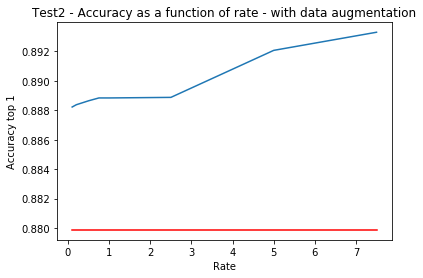

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 2s 52ms/step - loss: 0.5660 - accuracy: 0.8444
Epoch 2/10
41/41 [==============================] - 2s 51ms/step - loss: 0.5016 - accuracy: 0.8575
Epoch 3/10
41/41 [==============================] - 2s 48ms/step - loss: 0.4706 - accuracy: 0.8620
Epoch 4/10
41/41 [==============================] - 2s 52ms/step - loss: 0.4803 - accuracy: 0.8600
Epoch 5/10
41/41 [==============================] - 2s 47ms/step - loss: 0.4619 - accuracy: 0.8625
Epoch 6/10
41/41 [==============================] - 2s 45ms/step - loss: 0.4210 - accuracy: 0.8685
Epoch 7/10
41/41 [==============================] - 2s 54ms/step - loss: 0.4578 - accuracy: 0.8567
Epoch 8/10
41/41 [==============================] - 2s 45ms/step - loss: 0.4318 - accuracy: 0.8649
Epoch 9/10
41/41 [==============================]

65/65 [==============================] - 3s 50ms/step - loss: 0.4653 - accuracy: 0.8482
Epoch 3/10
65/65 [==============================] - 3s 46ms/step - loss: 0.4650 - accuracy: 0.8515
Epoch 4/10
65/65 [==============================] - 3s 45ms/step - loss: 0.4749 - accuracy: 0.8447
Epoch 5/10
65/65 [==============================] - 3s 45ms/step - loss: 0.4503 - accuracy: 0.8545
Epoch 6/10
65/65 [==============================] - 3s 48ms/step - loss: 0.4380 - accuracy: 0.8560
Epoch 7/10
65/65 [==============================] - 3s 48ms/step - loss: 0.4499 - accuracy: 0.8510
Epoch 8/10
65/65 [==============================] - 3s 49ms/step - loss: 0.4446 - accuracy: 0.8518
Epoch 9/10
65/65 [==============================] - 3s 50ms/step - loss: 0.4368 - accuracy: 0.8542
Epoch 10/10
65/65 [==============================] - 3s 47ms/step - loss: 0.4452 - accuracy: 0.8571
iteration:  1
Test loss: 0.37488582026907175
Test accuracy: 0.8898279070854187
rate=1.0:

n_total, n_true, n_pseudo:  1

313/313 [==============================] - 14s 43ms/step - loss: 0.6923 - accuracy: 0.7816
Epoch 3/10
313/313 [==============================] - 13s 42ms/step - loss: 0.6481 - accuracy: 0.7935
Epoch 4/10
313/313 [==============================] - 15s 47ms/step - loss: 0.6243 - accuracy: 0.7989
Epoch 5/10
313/313 [==============================] - 15s 47ms/step - loss: 0.6065 - accuracy: 0.8017
Epoch 6/10
313/313 [==============================] - 15s 48ms/step - loss: 0.5811 - accuracy: 0.8105
Epoch 7/10
313/313 [==============================] - 14s 45ms/step - loss: 0.5836 - accuracy: 0.8106
Epoch 8/10
313/313 [==============================] - 12s 40ms/step - loss: 0.5710 - accuracy: 0.8150
Epoch 9/10
313/313 [==============================] - 13s 42ms/step - loss: 0.5611 - accuracy: 0.8179
Epoch 10/10
313/313 [==============================] - 12s 40ms/step - loss: 0.5527 - accuracy: 0.8195
iteration:  0
Test loss: 0.36349105326883546
Test accuracy: 0.8937845826148987
1
Epoch 1/10


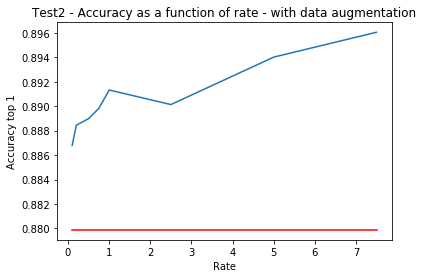

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5422, 32, 32, 3)
y_true_pseudo.shape:  (5422, 10)
0
Epoch 1/10
40/40 [==============================] - 2s 53ms/step - loss: 0.5597 - accuracy: 0.8519
Epoch 2/10
40/40 [==============================] - 2s 48ms/step - loss: 0.4758 - accuracy: 0.8689
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 0.4860 - accuracy: 0.8615
Epoch 4/10
40/40 [==============================] - 2s 48ms/step - loss: 0.4369 - accuracy: 0.8674
Epoch 5/10
40/40 [==============================] - 2s 48ms/step - loss: 0.4223 - accuracy: 0.8718
Epoch 6/10
40/40 [==============================] - 2s 54ms/step - loss: 0.4233 - accuracy: 0.8702
Epoch 7/10
40/40 [==============================] - 2s 50ms/step - loss: 0.4265 - accuracy: 0.8665
Epoch 8/10
40/40 [==============================] - 2s 46ms/step - loss: 0.4035 - accuracy: 0.8716
Epoch 9/10
40/40 [==============================]

61/61 [==============================] - 3s 44ms/step - loss: 0.3925 - accuracy: 0.8728
Epoch 3/10
61/61 [==============================] - 3s 50ms/step - loss: 0.3901 - accuracy: 0.8736
Epoch 4/10
61/61 [==============================] - 3s 52ms/step - loss: 0.3843 - accuracy: 0.8779
Epoch 5/10
61/61 [==============================] - 3s 47ms/step - loss: 0.3708 - accuracy: 0.8808
Epoch 6/10
61/61 [==============================] - 3s 49ms/step - loss: 0.3739 - accuracy: 0.8828
Epoch 7/10
61/61 [==============================] - 3s 49ms/step - loss: 0.3693 - accuracy: 0.8791
Epoch 8/10
61/61 [==============================] - 3s 48ms/step - loss: 0.3593 - accuracy: 0.8813
Epoch 9/10
61/61 [==============================] - 3s 48ms/step - loss: 0.3481 - accuracy: 0.8809
Epoch 10/10
61/61 [==============================] - 3s 48ms/step - loss: 0.3509 - accuracy: 0.8838
iteration:  1
Test loss: 0.38077352204793385
Test accuracy: 0.890673041343689
rate=1.0:

n_total, n_true, n_pseudo:  10

Epoch 3/10
271/271 [==============================] - 12s 43ms/step - loss: 0.4460 - accuracy: 0.8581
Epoch 4/10
271/271 [==============================] - 13s 47ms/step - loss: 0.4175 - accuracy: 0.8660
Epoch 5/10
271/271 [==============================] - 13s 49ms/step - loss: 0.4110 - accuracy: 0.8684
Epoch 6/10
271/271 [==============================] - 12s 44ms/step - loss: 0.3866 - accuracy: 0.8743
Epoch 7/10
271/271 [==============================] - 11s 42ms/step - loss: 0.3880 - accuracy: 0.8735
Epoch 8/10
271/271 [==============================] - 14s 50ms/step - loss: 0.3714 - accuracy: 0.8778
Epoch 9/10
271/271 [==============================] - 13s 49ms/step - loss: 0.3598 - accuracy: 0.8821
Epoch 10/10
271/271 [==============================] - 11s 42ms/step - loss: 0.3593 - accuracy: 0.8834
iteration:  0
Test loss: 0.3665082134608667
Test accuracy: 0.8927474021911621
1
Epoch 1/10
271/271 [==============================] - 14s 50ms/step - loss: 0.3422 - accuracy: 0.8885
E

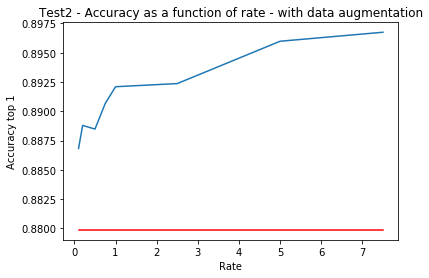

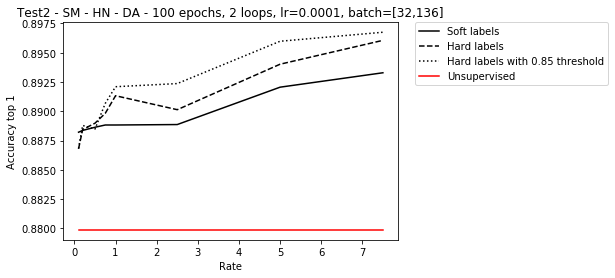

In [12]:
#Running Test2 for House Numbers DA with Simple model

accuracy4 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=False)

accuracy5 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy6 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


plt.plot(rate, accuracy4, 'k', label='Soft labels')
plt.plot(rate, accuracy5, 'k--', label='Hard labels')
plt.plot(rate, accuracy6, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - SM - HN - DA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
157/157 [==============================] - 14s 88ms/step - loss: 2.1992 - accuracy: 0.2914 - val_loss: 2.7150 - val_accuracy: 0.2160
Epoch 2/100
Learning rate:  0.001
  7/157 [>.............................] - ETA: 4s - loss: 1.7249 - accuracy: 0.4241

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


157/157 [==============================] - 7s 45ms/step - loss: 1.7930 - accuracy: 0.3992 - val_loss: 2.7334 - val_accuracy: 0.2286
Epoch 3/100
Learning rate:  0.001
157/157 [==============================] - 8s 50ms/step - loss: 1.6665 - accuracy: 0.4474 - val_loss: 1.8020 - val_accuracy: 0.4321
Epoch 4/100
Learning rate:  0.001
157/157 [==============================] - 8s 54ms/step - loss: 1.5382 - accuracy: 0.4880 - val_loss: 2.1847 - val_accuracy: 0.3795
Epoch 5/100
Learning rate:  0.001
157/157 [==============================] - 9s 55ms/step - loss: 1.4652 - accuracy: 0.5292 - val_loss: 1.4884 - val_accuracy: 0.5170
Epoch 6/100
Learning rate:  0.001
157/157 [==============================] - 9s 54ms/step - loss: 1.4010 - accuracy: 0.5556 - val_loss: 2.5762 - val_accuracy: 0.3560
Epoch 7/100
Learning rate:  0.001
157/157 [==============================] - 9s 55ms/step - loss: 1.3401 - accuracy: 0.5740 - val_loss: 1.4693 - val_accuracy: 0.5399
Epoch 8/100
Learning rate:  0.001
157/

157/157 [==============================] - 9s 55ms/step - loss: 0.5895 - accuracy: 0.8630 - val_loss: 1.4123 - val_accuracy: 0.6671
Epoch 52/100
Learning rate:  0.001
157/157 [==============================] - 9s 55ms/step - loss: 0.5502 - accuracy: 0.8772 - val_loss: 1.3044 - val_accuracy: 0.6915
Epoch 53/100
Learning rate:  0.001
157/157 [==============================] - 9s 57ms/step - loss: 0.5454 - accuracy: 0.8794 - val_loss: 1.3611 - val_accuracy: 0.6765
Epoch 54/100
Learning rate:  0.001
157/157 [==============================] - 9s 55ms/step - loss: 0.5692 - accuracy: 0.8770 - val_loss: 1.2811 - val_accuracy: 0.6864
Epoch 55/100
Learning rate:  0.001
157/157 [==============================] - 9s 55ms/step - loss: 0.5649 - accuracy: 0.8726 - val_loss: 1.4589 - val_accuracy: 0.6723
Epoch 56/100
Learning rate:  0.001
157/157 [==============================] - 9s 56ms/step - loss: 0.5330 - accuracy: 0.8888 - val_loss: 1.3934 - val_accuracy: 0.6906
Epoch 57/100
Learning rate:  0.00

10000/10000 [==============================] - 3s 263us/step
Supervised learning model with 100epochs 

Test loss: 1.2295923221588134
Test accuracy: 0.7541999816894531
Saved trained model at /home/ubuntu/saved_models/Resnet_cifar10_trained_teacher_5000.h5 
Small sample of 5000 training images, Supervised learning model with 100epochs 

Test accuracy: 0.7541999816894531
size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 7s 1ms/step - loss: 0.6780 - accuracy: 0.8545
Epoch 2/10
5500/5500 [==============================] - 2s 312us/step - loss: 0.6387 - accuracy: 0.8675
Epoch 3/10
5500/5500 [==============================] - 2s 310us/step - loss: 0.5998 - accuracy: 0.8798
Epoch 4/10
5500/5500 [==============================] - 1s 266us/step - loss: 0.5760 - accuracy: 0.8816
Epoch 5/10
5500/5500 [==============================] -

8750/8750 [==============================] - 3s 321us/step - loss: 0.7345 - accuracy: 0.8536
Epoch 6/10
8750/8750 [==============================] - 3s 311us/step - loss: 0.7136 - accuracy: 0.8656
Epoch 7/10
8750/8750 [==============================] - 3s 327us/step - loss: 0.6931 - accuracy: 0.8728
Epoch 8/10
8750/8750 [==============================] - 3s 316us/step - loss: 0.6966 - accuracy: 0.8730
Epoch 9/10
8750/8750 [==============================] - 3s 298us/step - loss: 0.6506 - accuracy: 0.8839
Epoch 10/10
8750/8750 [==============================] - 3s 320us/step - loss: 0.6496 - accuracy: 0.8826
iteration:  0
Test loss: 1.1308664777755737
Test accuracy: 0.7713000178337097
1
Epoch 1/10
8750/8750 [==============================] - 8s 929us/step - loss: 0.5764 - accuracy: 0.8939
Epoch 2/10
8750/8750 [==============================] - 3s 298us/step - loss: 0.5658 - accuracy: 0.8963
Epoch 3/10
8750/8750 [==============================] - 2s 286us/step - loss: 0.5566 - accuracy: 0

30000/30000 [==============================] - 9s 313us/step - loss: 0.6585 - accuracy: 0.8891
Epoch 4/10
30000/30000 [==============================] - 10s 318us/step - loss: 0.6464 - accuracy: 0.8957
Epoch 5/10
30000/30000 [==============================] - 9s 310us/step - loss: 0.6411 - accuracy: 0.8978
Epoch 6/10
30000/30000 [==============================] - 9s 304us/step - loss: 0.6285 - accuracy: 0.9022
Epoch 7/10
30000/30000 [==============================] - 9s 295us/step - loss: 0.6243 - accuracy: 0.9039
Epoch 8/10
30000/30000 [==============================] - 9s 316us/step - loss: 0.6156 - accuracy: 0.9111
Epoch 9/10
30000/30000 [==============================] - 9s 298us/step - loss: 0.6146 - accuracy: 0.9091
Epoch 10/10
30000/30000 [==============================] - 9s 300us/step - loss: 0.6044 - accuracy: 0.9174
iteration:  1
Test loss: 1.0295662647247315
Test accuracy: 0.7723000049591064
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (4250

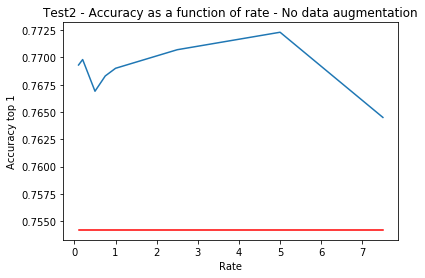

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 7s 1ms/step - loss: 0.6736 - accuracy: 0.8542
Epoch 2/10
5500/5500 [==============================] - 2s 304us/step - loss: 0.6333 - accuracy: 0.8578
Epoch 3/10
5500/5500 [==============================] - 2s 300us/step - loss: 0.5850 - accuracy: 0.8785
Epoch 4/10
5500/5500 [==============================] - 2s 341us/step - loss: 0.5542 - accuracy: 0.8889
Epoch 5/10
5500/5500 [==============================] - 2s 306us/step - loss: 0.5209 - accuracy: 0.9004
Epoch 6/10
5500/5500 [==============================] - 2s 307us/step - loss: 0.5115 - accuracy: 0.8956
Epoch 7/10
5500/5500 [==============================] - 2s 329us/step - loss: 0.4724 - accuracy: 0.9113
Epoch 8/10
5500/5500 [==============================] - 2s 312us/step - loss: 0.4710 - accuracy: 0.9093
Epoch 9/10


8750/8750 [==============================] - 3s 304us/step - loss: 0.5046 - accuracy: 0.8990
iteration:  0
Test loss: 1.1722715732574462
Test accuracy: 0.7703999876976013
1
Epoch 1/10
8750/8750 [==============================] - 8s 921us/step - loss: 0.4999 - accuracy: 0.9016
Epoch 2/10
8750/8750 [==============================] - 3s 318us/step - loss: 0.4993 - accuracy: 0.8979
Epoch 3/10
8750/8750 [==============================] - 3s 317us/step - loss: 0.4887 - accuracy: 0.9074
Epoch 4/10
8750/8750 [==============================] - 2s 278us/step - loss: 0.4619 - accuracy: 0.9151
Epoch 5/10
8750/8750 [==============================] - 3s 290us/step - loss: 0.4413 - accuracy: 0.9189
Epoch 6/10
8750/8750 [==============================] - 2s 278us/step - loss: 0.4399 - accuracy: 0.9239
Epoch 7/10
8750/8750 [==============================] - 3s 318us/step - loss: 0.4197 - accuracy: 0.9280
Epoch 8/10
8750/8750 [==============================] - 2s 276us/step - loss: 0.4133 - accuracy: 0.

30000/30000 [==============================] - 9s 306us/step - loss: 0.4122 - accuracy: 0.9292
Epoch 9/10
30000/30000 [==============================] - 9s 307us/step - loss: 0.3946 - accuracy: 0.9346
Epoch 10/10
30000/30000 [==============================] - 9s 297us/step - loss: 0.3797 - accuracy: 0.9392
iteration:  1
Test loss: 1.2842333006858826
Test accuracy: 0.7677000164985657
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (42500, 32, 32, 3)
y_true_pseudo.shape:  (42500, 10)
0
Epoch 1/10
42500/42500 [==============================] - 18s 429us/step - loss: 0.9598 - accuracy: 0.7774
Epoch 2/10
42500/42500 [==============================] - 13s 306us/step - loss: 0.8321 - accuracy: 0.8050
Epoch 3/10
42500/42500 [==============================] - 13s 317us/step - loss: 0.7592 - accuracy: 0.8222
Epoch 4/10
42500/42500 [==============================] - 13s 297us/step - loss: 0.7050 - accuracy: 0.8351
Epoch 5/10
42500/42500 [=============================

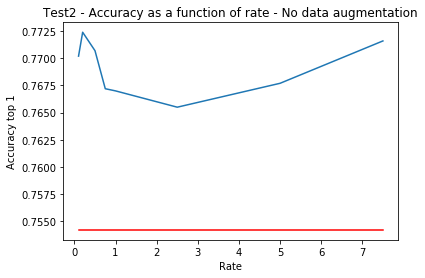

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5370, 32, 32, 3)
y_true_pseudo.shape:  (5370, 10)
0
Epoch 1/10
5370/5370 [==============================] - 7s 1ms/step - loss: 0.6347 - accuracy: 0.8635
Epoch 2/10
5370/5370 [==============================] - 2s 281us/step - loss: 0.5720 - accuracy: 0.8821
Epoch 3/10
5370/5370 [==============================] - 2s 281us/step - loss: 0.5600 - accuracy: 0.8851
Epoch 4/10
5370/5370 [==============================] - 2s 296us/step - loss: 0.5255 - accuracy: 0.8957
Epoch 5/10
5370/5370 [==============================] - 2s 307us/step - loss: 0.5010 - accuracy: 0.9024
Epoch 6/10
5370/5370 [==============================] - 2s 281us/step - loss: 0.4953 - accuracy: 0.9015
Epoch 7/10
5370/5370 [==============================] - 2s 302us/step - loss: 0.4659 - accuracy: 0.9115
Epoch 8/10
5370/5370 [==============================] - 2s 285us/step - loss: 0.4584 - accuracy: 0.9162
Epoch 9/10


7809/7809 [==============================] - 2s 275us/step - loss: 0.4314 - accuracy: 0.9235
iteration:  0
Test loss: 1.154463249874115
Test accuracy: 0.7746999859809875
1
Epoch 1/10
7809/7809 [==============================] - 7s 957us/step - loss: 0.4109 - accuracy: 0.9293
Epoch 2/10
7809/7809 [==============================] - 2s 307us/step - loss: 0.3913 - accuracy: 0.9365
Epoch 3/10
7809/7809 [==============================] - 2s 305us/step - loss: 0.3963 - accuracy: 0.9356
Epoch 4/10
7809/7809 [==============================] - 2s 290us/step - loss: 0.3752 - accuracy: 0.9449
Epoch 5/10
7809/7809 [==============================] - 2s 308us/step - loss: 0.3681 - accuracy: 0.9452
Epoch 6/10
7809/7809 [==============================] - 2s 283us/step - loss: 0.3664 - accuracy: 0.9460
Epoch 7/10
7809/7809 [==============================] - 2s 308us/step - loss: 0.3441 - accuracy: 0.9533
Epoch 8/10
7809/7809 [==============================] - 2s 293us/step - loss: 0.3461 - accuracy: 0.9

Epoch 9/10
23803/23803 [==============================] - 7s 296us/step - loss: 0.3143 - accuracy: 0.9623
Epoch 10/10
23803/23803 [==============================] - 7s 295us/step - loss: 0.3121 - accuracy: 0.9631
iteration:  1
Test loss: 1.2809334860801698
Test accuracy: 0.7692999839782715
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (33195, 32, 32, 3)
y_true_pseudo.shape:  (33195, 10)
0
Epoch 1/10
33195/33195 [==============================] - 16s 470us/step - loss: 0.6275 - accuracy: 0.8663
Epoch 2/10
33195/33195 [==============================] - 10s 302us/step - loss: 0.5295 - accuracy: 0.8933
Epoch 3/10
33195/33195 [==============================] - 10s 302us/step - loss: 0.4796 - accuracy: 0.9085
Epoch 4/10
33195/33195 [==============================] - 10s 287us/step - loss: 0.4540 - accuracy: 0.9165
Epoch 5/10
33195/33195 [==============================] - 10s 301us/step - loss: 0.4316 - accuracy: 0.9242
Epoch 6/10
33195/33195 [=================

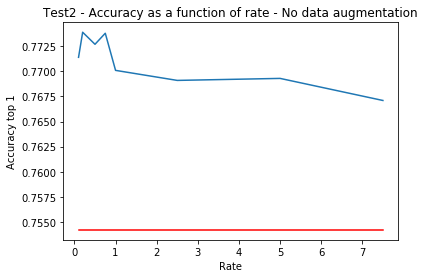

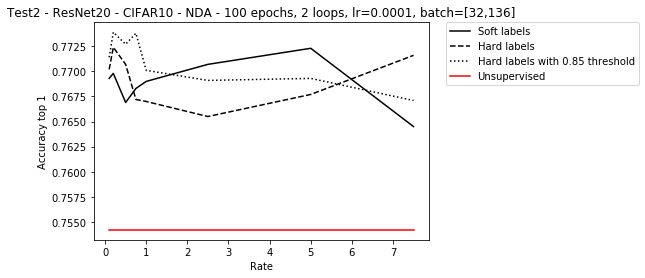

In [13]:
#Running Test2 for CIFAR10 NDA with Resnet

epochs=100
loops=2

num_classes=10
(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
rate=np.array([0.1,0.2,0.5,0.75,1,2.5,5, 7.5])
model_name= 'Resnet_cifar10_trained_teacher_5000.h5'

x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=num_classes)
    
accuracy_supervised, teacher_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
                                                      num_classes=num_classes, epochs=epochs, 
                                                       model_name= model_name)    
    
    
print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
print('Test accuracy:', accuracy_supervised)    

accuracy1 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=False)

accuracy2 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy3 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


supervised=[accuracy_supervised for i in range(len(rate))]

plt.plot(rate, accuracy1, 'k', label='Soft labels')
plt.plot(rate, accuracy2, 'k--', label='Hard labels')
plt.plot(rate, accuracy3, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - ResNet20 - CIFAR10 - NDA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 7s 172ms/step - loss: 0.7607 - accuracy: 0.8398
Epoch 2/10
41/41 [==============================] - 2s 56ms/step - loss: 0.7268 - accuracy: 0.8438
Epoch 3/10
41/41 [==============================] - 2s 54ms/step - loss: 0.6921 - accuracy: 0.8573
Epoch 4/10
41/41 [==============================] - 2s 53ms/step - loss: 0.6538 - accuracy: 0.8680
Epoch 5/10
41/41 [==============================] - 2s 53ms/step - loss: 0.6245 - accuracy: 0.8729
Epoch 6/10
41/41 [==============================] - 2s 58ms/step - loss: 0.6586 - accuracy: 0.8702
Epoch 7/10
41/41 [==============================] - 2s 58ms/step - loss: 0.6386 - accuracy: 0.8640
Epoch 8/10
41/41 [==============================] - 2s 52ms/step - loss: 0.6053 - accuracy: 0.8827
Epoch 9/10
41/41 [==============================

65/65 [==============================] - 3s 46ms/step - loss: 0.8284 - accuracy: 0.8282
Epoch 3/10
65/65 [==============================] - 3s 50ms/step - loss: 0.8160 - accuracy: 0.8343
Epoch 4/10
65/65 [==============================] - 4s 56ms/step - loss: 0.7837 - accuracy: 0.8405
Epoch 5/10
65/65 [==============================] - 4s 54ms/step - loss: 0.7722 - accuracy: 0.8378
Epoch 6/10
65/65 [==============================] - 4s 55ms/step - loss: 0.7599 - accuracy: 0.8406
Epoch 7/10
65/65 [==============================] - 4s 54ms/step - loss: 0.7679 - accuracy: 0.8455
Epoch 8/10
65/65 [==============================] - 4s 56ms/step - loss: 0.7511 - accuracy: 0.8475
Epoch 9/10
65/65 [==============================] - 3s 52ms/step - loss: 0.7470 - accuracy: 0.8490
Epoch 10/10
65/65 [==============================] - 3s 52ms/step - loss: 0.7319 - accuracy: 0.8515
iteration:  1
Test loss: 1.2596524213790894
Test accuracy: 0.7451000213623047
rate=1.0:

n_total, n_true, n_pseudo:  10

313/313 [==============================] - 16s 50ms/step - loss: 1.2877 - accuracy: 0.7404
Epoch 3/10
313/313 [==============================] - 16s 51ms/step - loss: 1.1905 - accuracy: 0.7499
Epoch 4/10
313/313 [==============================] - 14s 44ms/step - loss: 1.1206 - accuracy: 0.7552
Epoch 5/10
313/313 [==============================] - 16s 50ms/step - loss: 1.0756 - accuracy: 0.7591
Epoch 6/10
313/313 [==============================] - 14s 45ms/step - loss: 1.0244 - accuracy: 0.7681
Epoch 7/10
313/313 [==============================] - 15s 49ms/step - loss: 0.9998 - accuracy: 0.7729
Epoch 8/10
313/313 [==============================] - 16s 50ms/step - loss: 0.9737 - accuracy: 0.7787
Epoch 9/10
313/313 [==============================] - 16s 52ms/step - loss: 0.9637 - accuracy: 0.7798
Epoch 10/10
313/313 [==============================] - 14s 46ms/step - loss: 0.9388 - accuracy: 0.7851
iteration:  0
Test loss: 1.0766004145622254
Test accuracy: 0.7443000078201294
1
Epoch 1/10
3

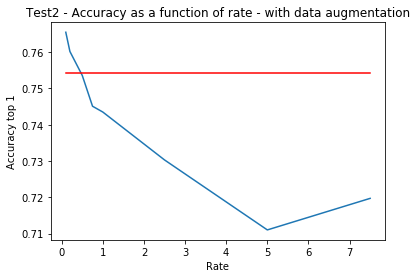

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 7s 167ms/step - loss: 0.7515 - accuracy: 0.8340
Epoch 2/10
41/41 [==============================] - 2s 54ms/step - loss: 0.7180 - accuracy: 0.8438
Epoch 3/10
41/41 [==============================] - 2s 52ms/step - loss: 0.6832 - accuracy: 0.8596
Epoch 4/10
41/41 [==============================] - 2s 52ms/step - loss: 0.6240 - accuracy: 0.8702
Epoch 5/10
41/41 [==============================] - 2s 55ms/step - loss: 0.6466 - accuracy: 0.8675
Epoch 6/10
41/41 [==============================] - 2s 53ms/step - loss: 0.6527 - accuracy: 0.8664
Epoch 7/10
41/41 [==============================] - 2s 51ms/step - loss: 0.6282 - accuracy: 0.8685
Epoch 8/10
41/41 [==============================] - 2s 53ms/step - loss: 0.5994 - accuracy: 0.8818
Epoch 9/10
41/41 [==============================

65/65 [==============================] - 3s 49ms/step - loss: 0.7640 - accuracy: 0.8408
Epoch 3/10
65/65 [==============================] - 3s 51ms/step - loss: 0.7632 - accuracy: 0.8369
Epoch 4/10
65/65 [==============================] - 3s 44ms/step - loss: 0.7438 - accuracy: 0.8415
Epoch 5/10
65/65 [==============================] - 3s 52ms/step - loss: 0.7208 - accuracy: 0.8416
Epoch 6/10
65/65 [==============================] - 3s 51ms/step - loss: 0.7249 - accuracy: 0.8430
Epoch 7/10
65/65 [==============================] - 3s 50ms/step - loss: 0.7043 - accuracy: 0.8529
Epoch 8/10
65/65 [==============================] - 3s 53ms/step - loss: 0.7065 - accuracy: 0.8469
Epoch 9/10
65/65 [==============================] - 3s 51ms/step - loss: 0.6766 - accuracy: 0.8567
Epoch 10/10
65/65 [==============================] - 3s 50ms/step - loss: 0.6781 - accuracy: 0.8498
iteration:  1
Test loss: 1.3098835523605348
Test accuracy: 0.7475000023841858
rate=1.0:

n_total, n_true, n_pseudo:  10

313/313 [==============================] - 14s 45ms/step - loss: 1.1921 - accuracy: 0.7390
Epoch 3/10
313/313 [==============================] - 16s 51ms/step - loss: 1.1039 - accuracy: 0.7509
Epoch 4/10
313/313 [==============================] - 16s 52ms/step - loss: 1.0428 - accuracy: 0.7600
Epoch 5/10
313/313 [==============================] - 15s 48ms/step - loss: 0.9852 - accuracy: 0.7668
Epoch 6/10
313/313 [==============================] - 16s 50ms/step - loss: 0.9552 - accuracy: 0.7714
Epoch 7/10
313/313 [==============================] - 15s 47ms/step - loss: 0.9288 - accuracy: 0.7740
Epoch 8/10
313/313 [==============================] - 14s 44ms/step - loss: 0.9103 - accuracy: 0.7784
Epoch 9/10
313/313 [==============================] - 14s 43ms/step - loss: 0.8851 - accuracy: 0.7822
Epoch 10/10
313/313 [==============================] - 14s 46ms/step - loss: 0.8683 - accuracy: 0.7856
iteration:  0
Test loss: 1.1518893335342408
Test accuracy: 0.7421000003814697
1
Epoch 1/10
3

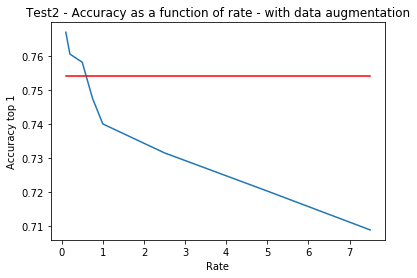

size x_total_unlabeled:  45000
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5370, 32, 32, 3)
y_true_pseudo.shape:  (5370, 10)
0
Epoch 1/10
40/40 [==============================] - 7s 176ms/step - loss: 0.6833 - accuracy: 0.8488
Epoch 2/10
40/40 [==============================] - 2s 57ms/step - loss: 0.6548 - accuracy: 0.8581
Epoch 3/10
40/40 [==============================] - 2s 55ms/step - loss: 0.6244 - accuracy: 0.8696
Epoch 4/10
40/40 [==============================] - 2s 58ms/step - loss: 0.5958 - accuracy: 0.8793
Epoch 5/10
40/40 [==============================] - 2s 55ms/step - loss: 0.5733 - accuracy: 0.8857
Epoch 6/10
40/40 [==============================] - 2s 53ms/step - loss: 0.5729 - accuracy: 0.8840
Epoch 7/10
40/40 [==============================] - 2s 56ms/step - loss: 0.5501 - accuracy: 0.8853
Epoch 8/10
40/40 [==============================] - 2s 51ms/step - loss: 0.5681 - accuracy: 0.8834
Epoch 9/10
40/40 [==============================

58/58 [==============================] - 3s 53ms/step - loss: 0.5816 - accuracy: 0.8837
Epoch 3/10
58/58 [==============================] - 3s 51ms/step - loss: 0.5720 - accuracy: 0.8860
Epoch 4/10
58/58 [==============================] - 3s 56ms/step - loss: 0.5600 - accuracy: 0.8887
Epoch 5/10
58/58 [==============================] - 3s 51ms/step - loss: 0.5453 - accuracy: 0.8927
Epoch 6/10
58/58 [==============================] - 3s 52ms/step - loss: 0.5451 - accuracy: 0.8914
Epoch 7/10
58/58 [==============================] - 3s 51ms/step - loss: 0.5382 - accuracy: 0.8924
Epoch 8/10
58/58 [==============================] - 3s 51ms/step - loss: 0.5208 - accuracy: 0.9024
Epoch 9/10
58/58 [==============================] - 3s 52ms/step - loss: 0.5033 - accuracy: 0.9034
Epoch 10/10
58/58 [==============================] - 3s 55ms/step - loss: 0.5078 - accuracy: 0.9040
iteration:  1
Test loss: 1.2668800562858582
Test accuracy: 0.7613999843597412
rate=1.0:

n_total, n_true, n_pseudo:  10

Epoch 3/10
245/245 [==============================] - 13s 52ms/step - loss: 0.7385 - accuracy: 0.8459
Epoch 4/10
245/245 [==============================] - 13s 51ms/step - loss: 0.7031 - accuracy: 0.8525
Epoch 5/10
245/245 [==============================] - 13s 52ms/step - loss: 0.6743 - accuracy: 0.8604
Epoch 6/10
245/245 [==============================] - 13s 51ms/step - loss: 0.6533 - accuracy: 0.8619
Epoch 7/10
245/245 [==============================] - 12s 51ms/step - loss: 0.6186 - accuracy: 0.8721
Epoch 8/10
245/245 [==============================] - 13s 53ms/step - loss: 0.6103 - accuracy: 0.8724
Epoch 9/10
245/245 [==============================] - 11s 44ms/step - loss: 0.5992 - accuracy: 0.8753
Epoch 10/10
245/245 [==============================] - 12s 50ms/step - loss: 0.5847 - accuracy: 0.8797
iteration:  0
Test loss: 1.2700411980628967
Test accuracy: 0.7476999759674072
1
Epoch 1/10
245/245 [==============================] - 17s 69ms/step - loss: 0.5836 - accuracy: 0.8817
E

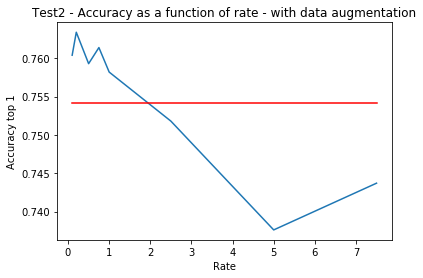

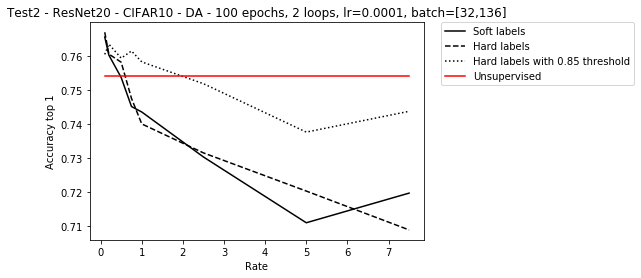

In [14]:
#Running Test2 for CIFAR10 DA with Resnet

accuracy4 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=False)

accuracy5 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy6 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


plt.plot(rate, accuracy4, 'k', label='Soft labels')
plt.plot(rate, accuracy5, 'k--', label='Hard labels')
plt.plot(rate, accuracy6, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - ResNet20 - CIFAR10 - DA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
157/157 [==============================] - 19s 120ms/step - loss: 2.5387 - accuracy: 0.1278 - val_loss: 2.5337 - val_accuracy: 0.1069
Epoch 2/100
Learning rate:  0.001
  7/157 [>.............................] - ETA: 4s - loss: 2.3685 - accuracy: 0.1741

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


157/157 [==============================] - 14s 88ms/step - loss: 2.1655 - accuracy: 0.2816 - val_loss: 2.9504 - val_accuracy: 0.1514
Epoch 3/100
Learning rate:  0.001
157/157 [==============================] - 14s 87ms/step - loss: 1.7011 - accuracy: 0.4652 - val_loss: 4.5769 - val_accuracy: 0.0993
Epoch 4/100
Learning rate:  0.001
157/157 [==============================] - 14s 91ms/step - loss: 1.3134 - accuracy: 0.6166 - val_loss: 1.5278 - val_accuracy: 0.5405
Epoch 5/100
Learning rate:  0.001
157/157 [==============================] - 13s 84ms/step - loss: 1.0800 - accuracy: 0.7018 - val_loss: 1.4296 - val_accuracy: 0.5637
Epoch 6/100
Learning rate:  0.001
157/157 [==============================] - 13s 85ms/step - loss: 0.9400 - accuracy: 0.7516 - val_loss: 1.0305 - val_accuracy: 0.7199
Epoch 7/100
Learning rate:  0.001
157/157 [==============================] - 12s 78ms/step - loss: 0.8413 - accuracy: 0.7834 - val_loss: 1.3384 - val_accuracy: 0.6116
Epoch 8/100
Learning rate:  0.00

157/157 [==============================] - 13s 81ms/step - loss: 0.3432 - accuracy: 0.9496 - val_loss: 0.6369 - val_accuracy: 0.8750
Epoch 52/100
Learning rate:  0.001
157/157 [==============================] - 13s 83ms/step - loss: 0.3435 - accuracy: 0.9478 - val_loss: 0.7678 - val_accuracy: 0.8384
Epoch 53/100
Learning rate:  0.001
157/157 [==============================] - 12s 79ms/step - loss: 0.3455 - accuracy: 0.9478 - val_loss: 1.0113 - val_accuracy: 0.7877
Epoch 54/100
Learning rate:  0.001
157/157 [==============================] - 13s 86ms/step - loss: 0.3345 - accuracy: 0.9498 - val_loss: 0.8344 - val_accuracy: 0.8219
Epoch 55/100
Learning rate:  0.001
157/157 [==============================] - 13s 83ms/step - loss: 0.3206 - accuracy: 0.9524 - val_loss: 0.6728 - val_accuracy: 0.8695
Epoch 56/100
Learning rate:  0.001
157/157 [==============================] - 13s 80ms/step - loss: 0.3470 - accuracy: 0.9458 - val_loss: 0.6988 - val_accuracy: 0.8634
Epoch 57/100
Learning rate:

Epoch 100/100
Learning rate:  0.0001
26032/26032 [==============================] - 8s 308us/step
Supervised learning model with 100epochs 

Test loss: 0.5759973146648735
Test accuracy: 0.9048863053321838
Saved trained model at /home/ubuntu/saved_models/Resnet_HN_trained_teacher_5000.h5 
Small sample of 5000 training images, Supervised learning model with 100epochs 

Test accuracy: 0.9048863053321838
size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 6s 1ms/step - loss: 0.3249 - accuracy: 0.9544
Epoch 2/10
5500/5500 [==============================] - 2s 320us/step - loss: 0.2983 - accuracy: 0.9607
Epoch 3/10
5500/5500 [==============================] - 2s 315us/step - loss: 0.2865 - accuracy: 0.9656
Epoch 4/10
5500/5500 [==============================] - 2s 278us/step - loss: 0.2772 - accuracy: 0.9693
Epoch 5/10
5500/5500 [=

8750/8750 [==============================] - 3s 288us/step - loss: 0.3701 - accuracy: 0.9480
Epoch 5/10
8750/8750 [==============================] - 3s 304us/step - loss: 0.3614 - accuracy: 0.9529
Epoch 6/10
8750/8750 [==============================] - 3s 305us/step - loss: 0.3480 - accuracy: 0.9568
Epoch 7/10
8750/8750 [==============================] - 3s 286us/step - loss: 0.3409 - accuracy: 0.9568
Epoch 8/10
8750/8750 [==============================] - 3s 298us/step - loss: 0.3369 - accuracy: 0.9622
Epoch 9/10
8750/8750 [==============================] - 2s 280us/step - loss: 0.3318 - accuracy: 0.9617
Epoch 10/10
8750/8750 [==============================] - 3s 316us/step - loss: 0.3305 - accuracy: 0.9633
iteration:  0
Test loss: 0.5166175339803714
Test accuracy: 0.9182928800582886
1
Epoch 1/10
8750/8750 [==============================] - 7s 836us/step - loss: 0.2907 - accuracy: 0.9691
Epoch 2/10
8750/8750 [==============================] - 3s 308us/step - loss: 0.2876 - accuracy: 0

30000/30000 [==============================] - 9s 302us/step - loss: 0.3578 - accuracy: 0.9618
Epoch 3/10
30000/30000 [==============================] - 9s 312us/step - loss: 0.3525 - accuracy: 0.9651
Epoch 4/10
30000/30000 [==============================] - 9s 305us/step - loss: 0.3482 - accuracy: 0.9651
Epoch 5/10
30000/30000 [==============================] - 9s 306us/step - loss: 0.3445 - accuracy: 0.9678
Epoch 6/10
30000/30000 [==============================] - 9s 308us/step - loss: 0.3404 - accuracy: 0.9683
Epoch 7/10
30000/30000 [==============================] - 9s 309us/step - loss: 0.3391 - accuracy: 0.9699
Epoch 8/10
30000/30000 [==============================] - 9s 297us/step - loss: 0.3348 - accuracy: 0.9699
Epoch 9/10
30000/30000 [==============================] - 9s 299us/step - loss: 0.3333 - accuracy: 0.9712
Epoch 10/10
30000/30000 [==============================] - 9s 305us/step - loss: 0.3302 - accuracy: 0.9712
iteration:  1
Test loss: 0.4608249293563552
Test accurac

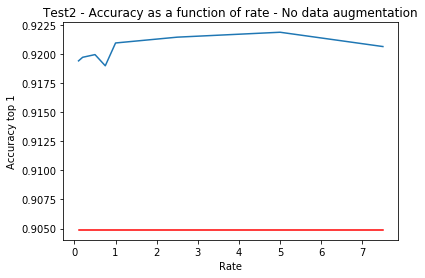

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
5500/5500 [==============================] - 6s 1ms/step - loss: 0.3125 - accuracy: 0.9544
Epoch 2/10
5500/5500 [==============================] - 2s 285us/step - loss: 0.2952 - accuracy: 0.9600
Epoch 3/10
5500/5500 [==============================] - 2s 331us/step - loss: 0.2740 - accuracy: 0.9662
Epoch 4/10
5500/5500 [==============================] - 2s 302us/step - loss: 0.2595 - accuracy: 0.9704
Epoch 5/10
5500/5500 [==============================] - 2s 304us/step - loss: 0.2571 - accuracy: 0.9718
Epoch 6/10
5500/5500 [==============================] - 2s 292us/step - loss: 0.2480 - accuracy: 0.9747
Epoch 7/10
5500/5500 [==============================] - 2s 290us/step - loss: 0.2417 - accuracy: 0.9765
Epoch 8/10
5500/5500 [==============================] - 2s 321us/step - loss: 0.2388 - accuracy: 0.9778
Epoch 9/10


Epoch 10/10
8750/8750 [==============================] - 3s 308us/step - loss: 0.2585 - accuracy: 0.9712
iteration:  0
Test loss: 0.5456250028772888
Test accuracy: 0.915642261505127
1
Epoch 1/10
8750/8750 [==============================] - 7s 820us/step - loss: 0.2478 - accuracy: 0.9733
Epoch 2/10
8750/8750 [==============================] - 3s 324us/step - loss: 0.2398 - accuracy: 0.9787
Epoch 3/10
8750/8750 [==============================] - 3s 314us/step - loss: 0.2350 - accuracy: 0.9795
Epoch 4/10
8750/8750 [==============================] - 3s 324us/step - loss: 0.2302 - accuracy: 0.9815
Epoch 5/10
8750/8750 [==============================] - 3s 322us/step - loss: 0.2306 - accuracy: 0.9810
Epoch 6/10
8750/8750 [==============================] - 3s 298us/step - loss: 0.2202 - accuracy: 0.9837
Epoch 7/10
8750/8750 [==============================] - 3s 309us/step - loss: 0.2219 - accuracy: 0.9834
Epoch 8/10
8750/8750 [==============================] - 3s 322us/step - loss: 0.2147 - a

30000/30000 [==============================] - 9s 295us/step - loss: 0.2162 - accuracy: 0.9836
Epoch 9/10
30000/30000 [==============================] - 9s 288us/step - loss: 0.2122 - accuracy: 0.9843
Epoch 10/10
30000/30000 [==============================] - 9s 292us/step - loss: 0.2079 - accuracy: 0.9856
iteration:  1
Test loss: 0.5774617894852022
Test accuracy: 0.9147971868515015
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (42500, 32, 32, 3)
y_true_pseudo.shape:  (42500, 10)
0
Epoch 1/10
42500/42500 [==============================] - 18s 416us/step - loss: 0.4457 - accuracy: 0.9137
Epoch 2/10
42500/42500 [==============================] - 13s 303us/step - loss: 0.3854 - accuracy: 0.9285
Epoch 3/10
42500/42500 [==============================] - 12s 293us/step - loss: 0.3605 - accuracy: 0.9356
Epoch 4/10
42500/42500 [==============================] - 13s 301us/step - loss: 0.3342 - accuracy: 0.9436
Epoch 5/10
42500/42500 [=============================

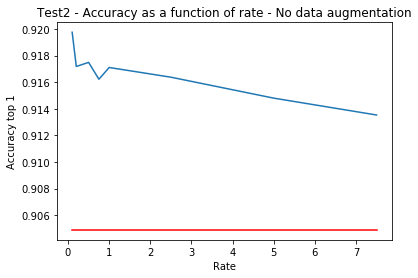

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5444, 32, 32, 3)
y_true_pseudo.shape:  (5444, 10)
0
Epoch 1/10
5444/5444 [==============================] - 7s 1ms/step - loss: 0.3129 - accuracy: 0.9559
Epoch 2/10
5444/5444 [==============================] - 2s 298us/step - loss: 0.2710 - accuracy: 0.9662
Epoch 3/10
5444/5444 [==============================] - 2s 297us/step - loss: 0.2760 - accuracy: 0.9680
Epoch 4/10
5444/5444 [==============================] - 2s 277us/step - loss: 0.2537 - accuracy: 0.9728
Epoch 5/10
5444/5444 [==============================] - 2s 327us/step - loss: 0.2586 - accuracy: 0.9730
Epoch 6/10
5444/5444 [==============================] - 2s 310us/step - loss: 0.2428 - accuracy: 0.9763
Epoch 7/10
5444/5444 [==============================] - 1s 260us/step - loss: 0.2456 - accuracy: 0.9756
Epoch 8/10
5444/5444 [==============================] - 2s 286us/step - loss: 0.2542 - accuracy: 0.9732
Epoch 9/10


8328/8328 [==============================] - 3s 314us/step - loss: 0.2204 - accuracy: 0.9840
iteration:  0
Test loss: 0.5320824470231338
Test accuracy: 0.9187538623809814
1
Epoch 1/10
8328/8328 [==============================] - 8s 940us/step - loss: 0.2184 - accuracy: 0.9849
Epoch 2/10
8328/8328 [==============================] - 2s 277us/step - loss: 0.2135 - accuracy: 0.9878
Epoch 3/10
8328/8328 [==============================] - 2s 299us/step - loss: 0.2126 - accuracy: 0.9864
Epoch 4/10
8328/8328 [==============================] - 2s 281us/step - loss: 0.2067 - accuracy: 0.9897
Epoch 5/10
8328/8328 [==============================] - 2s 296us/step - loss: 0.2083 - accuracy: 0.9893
Epoch 6/10
8328/8328 [==============================] - 2s 264us/step - loss: 0.2061 - accuracy: 0.9886
Epoch 7/10
8328/8328 [==============================] - 2s 287us/step - loss: 0.1997 - accuracy: 0.9916
Epoch 8/10
8328/8328 [==============================] - 2s 288us/step - loss: 0.1990 - accuracy: 0.

27223/27223 [==============================] - 8s 306us/step - loss: 0.1743 - accuracy: 0.9947
Epoch 9/10
27223/27223 [==============================] - 8s 289us/step - loss: 0.1718 - accuracy: 0.9956
Epoch 10/10
27223/27223 [==============================] - 8s 311us/step - loss: 0.1686 - accuracy: 0.9960
iteration:  1
Test loss: 0.534289630795082
Test accuracy: 0.9249769449234009
rate=7.5:

n_total, n_true, n_pseudo:  42500 5000 37500
x_true_pseudo.shape:  (38320, 32, 32, 3)
y_true_pseudo.shape:  (38320, 10)
0
Epoch 1/10
38320/38320 [==============================] - 16s 424us/step - loss: 0.3010 - accuracy: 0.9564
Epoch 2/10
38320/38320 [==============================] - 11s 274us/step - loss: 0.2568 - accuracy: 0.9717
Epoch 3/10
38320/38320 [==============================] - 11s 280us/step - loss: 0.2425 - accuracy: 0.9764
Epoch 4/10
38320/38320 [==============================] - 11s 297us/step - loss: 0.2313 - accuracy: 0.9809
Epoch 5/10
38320/38320 [==============================

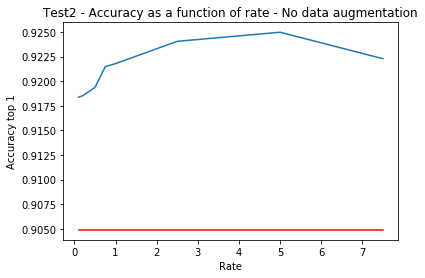

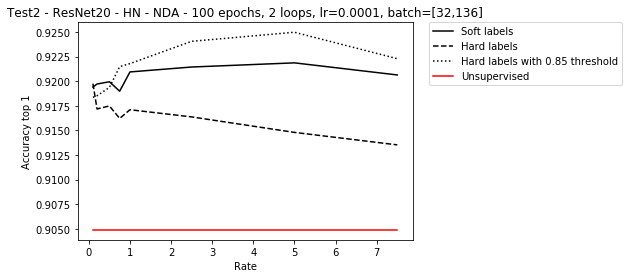

In [15]:
#Running Test2 for House Numbers NDA with Resnet

epochs=100
loops=2

num_classes=10
(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
rate=np.array([0.1,0.2,0.5,0.75,1,2.5,5, 7.5])
model_name= 'Resnet_HN_trained_teacher_5000.h5'

x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=num_classes)
    
accuracy_supervised, teacher_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
                                                      num_classes=num_classes, epochs=epochs, 
                                                       model_name= model_name)    
    
    
print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
print('Test accuracy:', accuracy_supervised)    

accuracy1 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=False)

accuracy2 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy3 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=False, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


supervised=[accuracy_supervised for i in range(len(rate))]

plt.plot(rate, accuracy1, 'k', label='Soft labels')
plt.plot(rate, accuracy2, 'k--', label='Hard labels')
plt.plot(rate, accuracy3, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - ResNet20 - HN - NDA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 7s 166ms/step - loss: 0.3397 - accuracy: 0.9476
Epoch 2/10
41/41 [==============================] - 2s 55ms/step - loss: 0.3439 - accuracy: 0.9500
Epoch 3/10
41/41 [==============================] - 2s 53ms/step - loss: 0.3251 - accuracy: 0.9536
Epoch 4/10
41/41 [==============================] - 2s 55ms/step - loss: 0.3205 - accuracy: 0.9562
Epoch 5/10
41/41 [==============================] - 2s 52ms/step - loss: 0.3165 - accuracy: 0.9576
Epoch 6/10
41/41 [==============================] - 2s 52ms/step - loss: 0.3016 - accuracy: 0.9667
Epoch 7/10
41/41 [==============================] - 2s 53ms/step - loss: 0.3000 - accuracy: 0.9635
Epoch 8/10
41/41 [==============================] - 2s 53ms/step - loss: 0.3029 - accuracy: 0.9627
Epoch 9/10
41/41 [==============================

65/65 [==============================] - 3s 50ms/step - loss: 0.3914 - accuracy: 0.9440
Epoch 3/10
65/65 [==============================] - 3s 49ms/step - loss: 0.3920 - accuracy: 0.9437
Epoch 4/10
65/65 [==============================] - 3s 53ms/step - loss: 0.3880 - accuracy: 0.9425
Epoch 5/10
65/65 [==============================] - 3s 53ms/step - loss: 0.3876 - accuracy: 0.9456
Epoch 6/10
65/65 [==============================] - 3s 51ms/step - loss: 0.3823 - accuracy: 0.9455
Epoch 7/10
65/65 [==============================] - 3s 52ms/step - loss: 0.3794 - accuracy: 0.9472
Epoch 8/10
65/65 [==============================] - 3s 50ms/step - loss: 0.3743 - accuracy: 0.9497
Epoch 9/10
65/65 [==============================] - 4s 55ms/step - loss: 0.3788 - accuracy: 0.9485
Epoch 10/10
65/65 [==============================] - 3s 52ms/step - loss: 0.3707 - accuracy: 0.9510
iteration:  1
Test loss: 0.5190292850695436
Test accuracy: 0.9173325300216675
rate=1.0:

n_total, n_true, n_pseudo:  10

313/313 [==============================] - 16s 51ms/step - loss: 0.6232 - accuracy: 0.8912
Epoch 3/10
313/313 [==============================] - 15s 48ms/step - loss: 0.5770 - accuracy: 0.8967
Epoch 4/10
313/313 [==============================] - 16s 52ms/step - loss: 0.5598 - accuracy: 0.9004
Epoch 5/10
313/313 [==============================] - 17s 53ms/step - loss: 0.5427 - accuracy: 0.9047
Epoch 6/10
313/313 [==============================] - 15s 47ms/step - loss: 0.5263 - accuracy: 0.9078
Epoch 7/10
313/313 [==============================] - 16s 52ms/step - loss: 0.5207 - accuracy: 0.9086
Epoch 8/10
313/313 [==============================] - 16s 51ms/step - loss: 0.5122 - accuracy: 0.9114
Epoch 9/10
313/313 [==============================] - 16s 51ms/step - loss: 0.5023 - accuracy: 0.9137
Epoch 10/10
313/313 [==============================] - 16s 50ms/step - loss: 0.4947 - accuracy: 0.9141
iteration:  0
Test loss: 0.4699321466131158
Test accuracy: 0.9189459085464478
1
Epoch 1/10
3

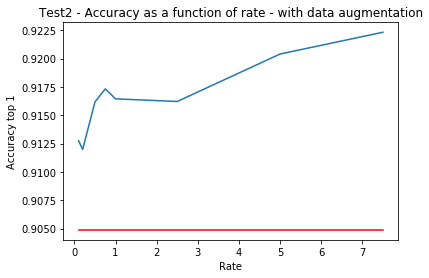

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5500, 32, 32, 3)
y_true_pseudo.shape:  (5500, 10)
0
Epoch 1/10
41/41 [==============================] - 7s 175ms/step - loss: 0.3433 - accuracy: 0.9445
Epoch 2/10
41/41 [==============================] - 2s 53ms/step - loss: 0.3282 - accuracy: 0.9524
Epoch 3/10
41/41 [==============================] - 2s 55ms/step - loss: 0.3165 - accuracy: 0.9540
Epoch 4/10
41/41 [==============================] - 2s 56ms/step - loss: 0.3059 - accuracy: 0.9542
Epoch 5/10
41/41 [==============================] - 2s 50ms/step - loss: 0.3124 - accuracy: 0.9587
Epoch 6/10
41/41 [==============================] - 2s 54ms/step - loss: 0.2982 - accuracy: 0.9611
Epoch 7/10
41/41 [==============================] - 2s 56ms/step - loss: 0.2846 - accuracy: 0.9651
Epoch 8/10
41/41 [==============================] - 2s 49ms/step - loss: 0.2927 - accuracy: 0.9635
Epoch 9/10
41/41 [==============================

65/65 [==============================] - 3s 54ms/step - loss: 0.3648 - accuracy: 0.9399
Epoch 3/10
65/65 [==============================] - 4s 55ms/step - loss: 0.3557 - accuracy: 0.9454
Epoch 4/10
65/65 [==============================] - 4s 54ms/step - loss: 0.3641 - accuracy: 0.9450
Epoch 5/10
65/65 [==============================] - 3s 52ms/step - loss: 0.3415 - accuracy: 0.9485
Epoch 6/10
65/65 [==============================] - 3s 52ms/step - loss: 0.3405 - accuracy: 0.9472
Epoch 7/10
65/65 [==============================] - 3s 46ms/step - loss: 0.3454 - accuracy: 0.9489
Epoch 8/10
65/65 [==============================] - 3s 52ms/step - loss: 0.3315 - accuracy: 0.9525
Epoch 9/10
65/65 [==============================] - 3s 53ms/step - loss: 0.3386 - accuracy: 0.9514
Epoch 10/10
65/65 [==============================] - 3s 53ms/step - loss: 0.3314 - accuracy: 0.9550
iteration:  1
Test loss: 0.5396922207091144
Test accuracy: 0.9148355722427368
rate=1.0:

n_total, n_true, n_pseudo:  10

313/313 [==============================] - 14s 46ms/step - loss: 0.5568 - accuracy: 0.8936
Epoch 3/10
313/313 [==============================] - 16s 52ms/step - loss: 0.5269 - accuracy: 0.8978
Epoch 4/10
313/313 [==============================] - 16s 50ms/step - loss: 0.5054 - accuracy: 0.9019
Epoch 5/10
313/313 [==============================] - 14s 46ms/step - loss: 0.4894 - accuracy: 0.9050
Epoch 6/10
313/313 [==============================] - 15s 47ms/step - loss: 0.4782 - accuracy: 0.9086
Epoch 7/10
313/313 [==============================] - 16s 51ms/step - loss: 0.4646 - accuracy: 0.9100
Epoch 8/10
313/313 [==============================] - 16s 51ms/step - loss: 0.4617 - accuracy: 0.9121
Epoch 9/10
313/313 [==============================] - 17s 55ms/step - loss: 0.4485 - accuracy: 0.9139
Epoch 10/10
313/313 [==============================] - 15s 49ms/step - loss: 0.4432 - accuracy: 0.9151
iteration:  0
Test loss: 0.48670238707061186
Test accuracy: 0.918023943901062
1
Epoch 1/10
3

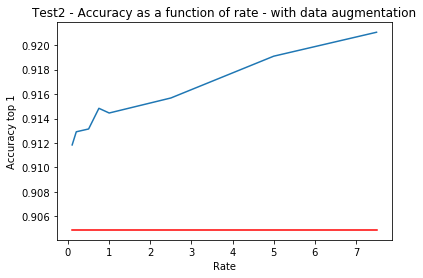

size x_total_unlabeled:  68257
rate=0.1:

n_total, n_true, n_pseudo:  5500 5000 500
x_true_pseudo.shape:  (5444, 32, 32, 3)
y_true_pseudo.shape:  (5444, 10)
0
Epoch 1/10
41/41 [==============================] - 7s 168ms/step - loss: 0.3234 - accuracy: 0.9489
Epoch 2/10
41/41 [==============================] - 2s 56ms/step - loss: 0.3362 - accuracy: 0.9539
Epoch 3/10
41/41 [==============================] - 2s 54ms/step - loss: 0.3078 - accuracy: 0.9581
Epoch 4/10
41/41 [==============================] - 2s 51ms/step - loss: 0.3231 - accuracy: 0.9587
Epoch 5/10
41/41 [==============================] - 2s 53ms/step - loss: 0.2921 - accuracy: 0.9587
Epoch 6/10
41/41 [==============================] - 2s 51ms/step - loss: 0.3007 - accuracy: 0.9662
Epoch 7/10
41/41 [==============================] - 2s 55ms/step - loss: 0.2954 - accuracy: 0.9642
Epoch 8/10
41/41 [==============================] - 2s 49ms/step - loss: 0.2708 - accuracy: 0.9664
Epoch 9/10
41/41 [==============================

62/62 [==============================] - 3s 54ms/step - loss: 0.2865 - accuracy: 0.9629
Epoch 3/10
62/62 [==============================] - 3s 50ms/step - loss: 0.2777 - accuracy: 0.9673
Epoch 4/10
62/62 [==============================] - 3s 53ms/step - loss: 0.2769 - accuracy: 0.9657
Epoch 5/10
62/62 [==============================] - 3s 53ms/step - loss: 0.2811 - accuracy: 0.9657
Epoch 6/10
62/62 [==============================] - 3s 55ms/step - loss: 0.2809 - accuracy: 0.9665
Epoch 7/10
62/62 [==============================] - 3s 55ms/step - loss: 0.2785 - accuracy: 0.9671
Epoch 8/10
62/62 [==============================] - 3s 54ms/step - loss: 0.2723 - accuracy: 0.9715
Epoch 9/10
62/62 [==============================] - 3s 54ms/step - loss: 0.2711 - accuracy: 0.9691
Epoch 10/10
62/62 [==============================] - 3s 55ms/step - loss: 0.2665 - accuracy: 0.9711
iteration:  1
Test loss: 0.54076651975137
Test accuracy: 0.9165258407592773
rate=1.0:

n_total, n_true, n_pseudo:  1000

282/282 [==============================] - 15s 52ms/step - loss: 0.3704 - accuracy: 0.9416
Epoch 3/10
282/282 [==============================] - 15s 53ms/step - loss: 0.3471 - accuracy: 0.9478
Epoch 4/10
282/282 [==============================] - 13s 47ms/step - loss: 0.3362 - accuracy: 0.9519
Epoch 5/10
282/282 [==============================] - 15s 53ms/step - loss: 0.3279 - accuracy: 0.9540
Epoch 6/10
282/282 [==============================] - 14s 48ms/step - loss: 0.3174 - accuracy: 0.9559
Epoch 7/10
282/282 [==============================] - 15s 53ms/step - loss: 0.3093 - accuracy: 0.9581
Epoch 8/10
282/282 [==============================] - 14s 48ms/step - loss: 0.3024 - accuracy: 0.9601
Epoch 9/10
282/282 [==============================] - 14s 48ms/step - loss: 0.2970 - accuracy: 0.9610
Epoch 10/10
282/282 [==============================] - 15s 54ms/step - loss: 0.2917 - accuracy: 0.9619
iteration:  0
Test loss: 0.5086748711192396
Test accuracy: 0.9189459085464478
1
Epoch 1/10
2

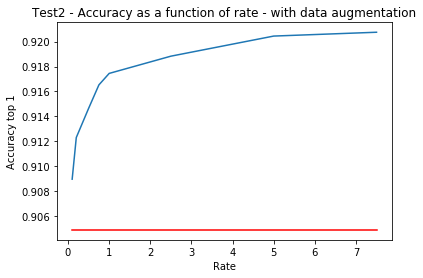

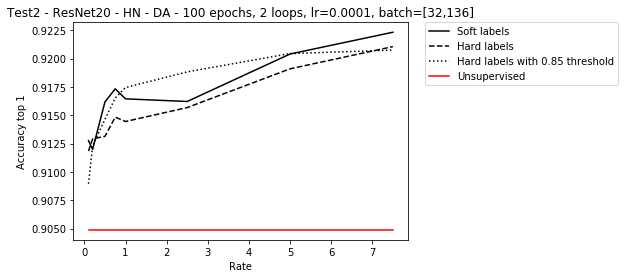

In [16]:
accuracy4 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=False)

accuracy5 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.)

accuracy6 = stns_5000(accuracy_supervised, mask2, teacher_path, x_train,x_test,y_test,rate,teacher, student, sample_size=5000,
              data_augmentation=True, lr=0.0001, loops=2, hard_labels=True,proba=0.85)


plt.plot(rate, accuracy4, 'k', label='Soft labels')
plt.plot(rate, accuracy5, 'k--', label='Hard labels')
plt.plot(rate, accuracy6, 'k:', label='Hard labels with 0.85 threshold')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test2 - ResNet20 - HN - DA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()

# Test 1

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
1563/1563 [==============================] - 64s 41ms/step - loss: 1.5558 - accuracy: 0.4926 - val_loss: 1.3151 - val_accuracy: 0.5902
Epoch 2/100
Learning rate:  0.001
   3/1563 [..............................] - ETA: 1:27 - loss: 1.0772 - accuracy: 0.6667

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1563/1563 [==============================] - 54s 34ms/step - loss: 1.1904 - accuracy: 0.6319 - val_loss: 1.0779 - val_accuracy: 0.6770
Epoch 3/100
Learning rate:  0.001
1563/1563 [==============================] - 59s 38ms/step - loss: 1.0284 - accuracy: 0.6963 - val_loss: 1.0753 - val_accuracy: 0.6868
Epoch 4/100
Learning rate:  0.001
1563/1563 [==============================] - 58s 37ms/step - loss: 0.9337 - accuracy: 0.7318 - val_loss: 1.0332 - val_accuracy: 0.6992
Epoch 5/100
Learning rate:  0.001
1563/1563 [==============================] - 59s 38ms/step - loss: 0.8733 - accuracy: 0.7571 - val_loss: 2.2209 - val_accuracy: 0.5104
Epoch 6/100
Learning rate:  0.001
1563/1563 [==============================] - 60s 38ms/step - loss: 0.8206 - accuracy: 0.7781 - val_loss: 0.8883 - val_accuracy: 0.7612
Epoch 7/100
Learning rate:  0.001
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7832 - accuracy: 0.7907 - val_loss: 0.8407 - val_accuracy: 0.7802
Epoch 8/100
Learning

1563/1563 [==============================] - 56s 36ms/step - loss: 0.5250 - accuracy: 0.8909 - val_loss: 0.6574 - val_accuracy: 0.8533
Epoch 51/100
Learning rate:  0.001
1563/1563 [==============================] - 60s 38ms/step - loss: 0.5265 - accuracy: 0.8911 - val_loss: 0.7561 - val_accuracy: 0.8331
Epoch 52/100
Learning rate:  0.001
1563/1563 [==============================] - 51s 33ms/step - loss: 0.5234 - accuracy: 0.8934 - val_loss: 0.7464 - val_accuracy: 0.8350
Epoch 53/100
Learning rate:  0.001
1563/1563 [==============================] - 58s 37ms/step - loss: 0.5251 - accuracy: 0.8913 - val_loss: 0.6931 - val_accuracy: 0.8473
Epoch 54/100
Learning rate:  0.001
1563/1563 [==============================] - 56s 36ms/step - loss: 0.5240 - accuracy: 0.8901 - val_loss: 0.9280 - val_accuracy: 0.7893
Epoch 55/100
Learning rate:  0.001
1563/1563 [==============================] - 49s 31ms/step - loss: 0.5167 - accuracy: 0.8953 - val_loss: 0.8080 - val_accuracy: 0.8159
Epoch 56/100
Le

1563/1563 [==============================] - 57s 36ms/step - loss: 0.2728 - accuracy: 0.9615 - val_loss: 0.4549 - val_accuracy: 0.9124
Epoch 99/100
Learning rate:  0.0001
1563/1563 [==============================] - 59s 38ms/step - loss: 0.2684 - accuracy: 0.9618 - val_loss: 0.4643 - val_accuracy: 0.9112
Epoch 100/100
Learning rate:  0.0001
10000/10000 [==============================] - 3s 281us/step
Supervised learning model with 100epochs 

Test loss: 0.4509226467132568
Test accuracy: 0.9135000109672546
Saved trained model at /home/ubuntu/saved_models/cifar10_test1.h5 
rate=0.1:

Learning rate:  0.001
Original model with labelled data only predicting on test data:  0.9135000109672546
x_true_pseudo.shape:  (50000, 32, 32, 3)
y_true_pseudo.shape:  (50000, 10)
Epoch 1/10
50000/50000 [==============================] - 20s 390us/step - loss: 0.5518 - accuracy: 0.8765
Epoch 2/10
50000/50000 [==============================] - 14s 280us/step - loss: 0.4272 - accuracy: 0.9090
Epoch 3/10
50000

Learning rate:  0.001
Original model with labelled data only predicting on test data:  0.9135000109672546
x_true_pseudo.shape:  (50000, 32, 32, 3)
y_true_pseudo.shape:  (50000, 10)
Epoch 1/10
50000/50000 [==============================] - 19s 386us/step - loss: 0.5640 - accuracy: 0.8792
Epoch 2/10
50000/50000 [==============================] - 14s 288us/step - loss: 0.4493 - accuracy: 0.9075
Epoch 3/10
50000/50000 [==============================] - 15s 302us/step - loss: 0.4058 - accuracy: 0.9217
Epoch 4/10
50000/50000 [==============================] - 15s 306us/step - loss: 0.3759 - accuracy: 0.9340
Epoch 5/10
50000/50000 [==============================] - 16s 311us/step - loss: 0.3557 - accuracy: 0.9402
Epoch 6/10
50000/50000 [==============================] - 15s 303us/step - loss: 0.3444 - accuracy: 0.9432
Epoch 7/10
50000/50000 [==============================] - 15s 307us/step - loss: 0.3325 - accuracy: 0.9491
Epoch 8/10
50000/50000 [==============================] - 15s 294us/st

50000/50000 [==============================] - 13s 268us/step - loss: 0.3735 - accuracy: 0.9422
Epoch 7/10
50000/50000 [==============================] - 15s 299us/step - loss: 0.3606 - accuracy: 0.9479
Epoch 8/10
50000/50000 [==============================] - 15s 296us/step - loss: 0.3519 - accuracy: 0.9514
Epoch 9/10
50000/50000 [==============================] - 14s 278us/step - loss: 0.3408 - accuracy: 0.9563
Epoch 10/10
50000/50000 [==============================] - 15s 310us/step - loss: 0.3349 - accuracy: 0.9567
iteration:  0
Test loss: 0.42180033946037293
Test accuracy: 0.9193999767303467
Epoch 1/10
50000/50000 [==============================] - 20s 391us/step - loss: 0.3237 - accuracy: 0.9636
Epoch 2/10
50000/50000 [==============================] - 15s 307us/step - loss: 0.3186 - accuracy: 0.9647
Epoch 3/10
50000/50000 [==============================] - 16s 315us/step - loss: 0.3107 - accuracy: 0.9687
Epoch 4/10
50000/50000 [==============================] - 15s 308us/step - 

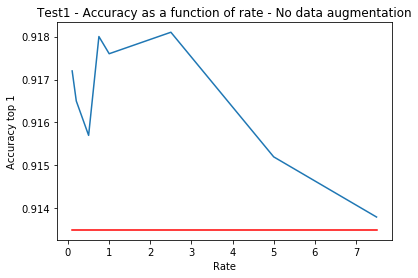

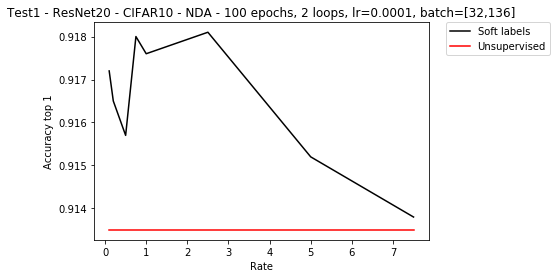

In [20]:
#Test1
#Restnet20 on full CIFAR10 train dataset without data augmentation

epochs=100
loops=2

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, 
                                                epochs=epochs, model_name= 'cifar10_test1.h5')

rate=np.array([0.1, 0.2,0.5,0.75,1,2.5,5,7.5])
accuracy=stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, 
                           data_augmentation=False, loops=loops, lr=0.0001, hard_labels=False)

supervised=[accuracy_supervised for i in range(len(rate))]

plt.plot(rate, accuracy, 'k', label='Soft labels')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test1 - ResNet20 - CIFAR10 - NDA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()



Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
2290/2290 [==============================] - 96s 42ms/step - loss: 1.0297 - accuracy: 0.7126 - val_loss: 0.6395 - val_accuracy: 0.8539
Epoch 2/100
Learning rate:  0.001
   3/2290 [..............................] - ETA: 1:07 - loss: 0.5467 - accuracy: 0.8646

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2290/2290 [==============================] - 92s 40ms/step - loss: 0.5881 - accuracy: 0.8678 - val_loss: 0.5738 - val_accuracy: 0.8728
Epoch 3/100
Learning rate:  0.001
2290/2290 [==============================] - 91s 40ms/step - loss: 0.5225 - accuracy: 0.8886 - val_loss: 0.5237 - val_accuracy: 0.8847
Epoch 4/100
Learning rate:  0.001
2290/2290 [==============================] - 90s 40ms/step - loss: 0.4871 - accuracy: 0.8992 - val_loss: 0.4582 - val_accuracy: 0.9089
Epoch 5/100
Learning rate:  0.001
2290/2290 [==============================] - 90s 40ms/step - loss: 0.4659 - accuracy: 0.9051 - val_loss: 0.4192 - val_accuracy: 0.9179
Epoch 6/100
Learning rate:  0.001
2290/2290 [==============================] - 90s 39ms/step - loss: 0.4497 - accuracy: 0.9093 - val_loss: 0.4563 - val_accuracy: 0.9089
Epoch 7/100
Learning rate:  0.001
2290/2290 [==============================] - 90s 39ms/step - loss: 0.4340 - accuracy: 0.9126 - val_loss: 0.4754 - val_accuracy: 0.8974
Epoch 8/100
Learning

2290/2290 [==============================] - 90s 39ms/step - loss: 0.3219 - accuracy: 0.9387 - val_loss: 0.3276 - val_accuracy: 0.9397
Epoch 51/100
Learning rate:  0.001
2290/2290 [==============================] - 90s 39ms/step - loss: 0.3204 - accuracy: 0.9383 - val_loss: 0.3499 - val_accuracy: 0.9310
Epoch 52/100
Learning rate:  0.001
2290/2290 [==============================] - 92s 40ms/step - loss: 0.3223 - accuracy: 0.9371 - val_loss: 0.3347 - val_accuracy: 0.9370
Epoch 53/100
Learning rate:  0.001
2290/2290 [==============================] - 92s 40ms/step - loss: 0.3195 - accuracy: 0.9378 - val_loss: 0.3252 - val_accuracy: 0.9405
Epoch 54/100
Learning rate:  0.001
2290/2290 [==============================] - 89s 39ms/step - loss: 0.3179 - accuracy: 0.9383 - val_loss: 0.3580 - val_accuracy: 0.9273
Epoch 55/100
Learning rate:  0.001
2290/2290 [==============================] - 92s 40ms/step - loss: 0.3185 - accuracy: 0.9387 - val_loss: 0.3177 - val_accuracy: 0.9424
Epoch 56/100
Le

2290/2290 [==============================] - 92s 40ms/step - loss: 0.1854 - accuracy: 0.9698 - val_loss: 0.2304 - val_accuracy: 0.9578
Epoch 99/100
Learning rate:  0.0001
2290/2290 [==============================] - 92s 40ms/step - loss: 0.1831 - accuracy: 0.9697 - val_loss: 0.2307 - val_accuracy: 0.9584
Epoch 100/100
Learning rate:  0.0001
26032/26032 [==============================] - 6s 223us/step
Supervised learning model with 100epochs 

Test loss: 0.23025260494762062
Test accuracy: 0.957897961139679
Saved trained model at /home/ubuntu/saved_models/HN_test1.h5 
rate=0.1:

Learning rate:  0.001
Original model with labelled data only predicting on test data:  0.957897961139679
x_true_pseudo.shape:  (73257, 32, 32, 3)
y_true_pseudo.shape:  (73257, 10)
Epoch 1/10
73257/73257 [==============================] - 27s 369us/step - loss: 0.2797 - accuracy: 0.9450
Epoch 2/10
73257/73257 [==============================] - 21s 287us/step - loss: 0.2310 - accuracy: 0.9615
Epoch 3/10
73257/73257

Learning rate:  0.001
Original model with labelled data only predicting on test data:  0.957897961139679
x_true_pseudo.shape:  (73257, 32, 32, 3)
y_true_pseudo.shape:  (73257, 10)
Epoch 1/10
73257/73257 [==============================] - 27s 369us/step - loss: 0.2843 - accuracy: 0.9478
Epoch 2/10
73257/73257 [==============================] - 22s 294us/step - loss: 0.2402 - accuracy: 0.9652
Epoch 3/10
73257/73257 [==============================] - 21s 290us/step - loss: 0.2278 - accuracy: 0.9688
Epoch 4/10
73257/73257 [==============================] - 23s 312us/step - loss: 0.2180 - accuracy: 0.9721
Epoch 5/10
73257/73257 [==============================] - 22s 297us/step - loss: 0.2084 - accuracy: 0.9745
Epoch 6/10
73257/73257 [==============================] - 22s 299us/step - loss: 0.2033 - accuracy: 0.9770
Epoch 7/10
73257/73257 [==============================] - 22s 297us/step - loss: 0.1989 - accuracy: 0.9781
Epoch 8/10
73257/73257 [==============================] - 22s 298us/ste

73257/73257 [==============================] - 22s 304us/step - loss: 0.2196 - accuracy: 0.9791
Epoch 7/10
73257/73257 [==============================] - 22s 306us/step - loss: 0.2159 - accuracy: 0.9800
Epoch 8/10
73257/73257 [==============================] - 23s 309us/step - loss: 0.2129 - accuracy: 0.9812
Epoch 9/10
73257/73257 [==============================] - 23s 309us/step - loss: 0.2088 - accuracy: 0.9820
Epoch 10/10
73257/73257 [==============================] - 22s 299us/step - loss: 0.2061 - accuracy: 0.9820
iteration:  0
Test loss: 0.20806636534443498
Test accuracy: 0.9633143544197083
Epoch 1/10
73257/73257 [==============================] - 28s 376us/step - loss: 0.1755 - accuracy: 0.9848
Epoch 2/10
73257/73257 [==============================] - 22s 306us/step - loss: 0.1727 - accuracy: 0.9855
Epoch 3/10
73257/73257 [==============================] - 22s 301us/step - loss: 0.1694 - accuracy: 0.9862
Epoch 4/10
73257/73257 [==============================] - 22s 306us/step - 

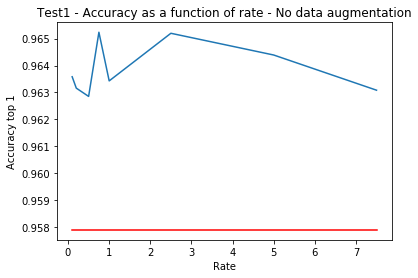

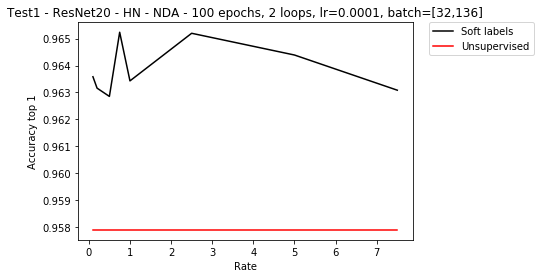

In [21]:
#Test1
#Restnet20 on full House numbers train dataset without data augmentation

epochs=100
loops=2

(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, 
                                                epochs=epochs, model_name= 'HN_test1.h5')

rate=np.array([0.1, 0.2,0.5,0.75,1,2.5,5,7.5])
accuracy=stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, 
                           data_augmentation=False, loops=loops, lr=0.0001, hard_labels=False)

supervised=[accuracy_supervised for i in range(len(rate))]

plt.plot(rate, accuracy, 'k', label='Soft labels')
plt.plot(rate, supervised, 'r', label='supervised')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Rate')
plt.ylabel('Accuracy top 1')
plt.title('Test1 - ResNet20 - HN - NDA - 100 epochs, 2 loops, lr=0.0001, batch=[32,136]')
plt.show()
